# Prediabetes vs. Diabetes Logistic Regression Modeling

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import yellowbrick

#sn.set(rc={'figure.figsize':(10,5)})

In [2]:
data = pd.read_csv('total_cleaned.csv')
data.head

<bound method NDFrame.head of         DIABETE3  _BMI5  SMOKE100  CVDSTRK3  _TOTINDA  HLTHPLN1  MEDCOST  \
0            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
1            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
2            0.0   35.0       1.0       0.0       0.0       1.0      1.0   
3            1.0   43.0       1.0       0.0       1.0       1.0      0.0   
4            0.0   22.0       0.0       0.0       1.0       0.0      1.0   
...          ...    ...       ...       ...       ...       ...      ...   
528789       0.0   27.0       0.0       0.0       0.0       1.0      1.0   
528790       2.0   25.0       0.0       0.0       0.0       1.0      0.0   
528791       0.0   23.0       0.0       1.0       0.0       1.0      1.0   
528792       0.0   42.0       0.0       0.0       1.0       1.0      0.0   
528793       0.0   45.0       0.0       0.0       0.0       1.0      0.0   

        GENHLTH  MENTHLTH  PHYSHLTH  SEX  _AGEG5YR  EDUCA

In [3]:
data = data.rename(
    columns = 
    {'DIABETE3':'Diabetes_012',
     '_BMI5':'BMI',
     'SMOKE100':'Smoker',
     'CVDSTRK3':'Stroke',
     '_TOTINDA':'PhysActivity',
     'HLTHPLN1':'AnyHealthcare',
     'MEDCOST':'NoDocbcCost',
     'GENHLTH':'GenHlth',
     'MENTHLTH':'MentHlth',
     'PHYSHLTH':'PhysHlth',
     'SEX':'Sex',
     '_AGE5YR':'Age',
     'EDUCA':'Education',
     'INCOME2':'Income',
     'MARITAL':'Marital',
     'POORHLTH':'PoorHlth',
     'CVDINFR4':'HeartAttack',
     '_RFHYPE5':'HighBP',
     '_AGEG5YR':'Age'
    }
)

In [4]:
data.isna().sum()

Diabetes_012     0
BMI              0
Smoker           0
Stroke           0
PhysActivity     0
AnyHealthcare    0
NoDocbcCost      0
GenHlth          0
MentHlth         0
PhysHlth         0
Sex              0
Age              0
Education        0
Income           0
Marital          0
PoorHlth         0
HeartAttack      0
HighBP           0
dtype: int64

In [5]:
data.dtypes

Diabetes_012     float64
BMI              float64
Smoker           float64
Stroke           float64
PhysActivity     float64
AnyHealthcare    float64
NoDocbcCost      float64
GenHlth          float64
MentHlth         float64
PhysHlth         float64
Sex              float64
Age              float64
Education        float64
Income           float64
Marital          float64
PoorHlth         float64
HeartAttack      float64
HighBP           float64
dtype: object

## Variable of Interest

<AxesSubplot: >

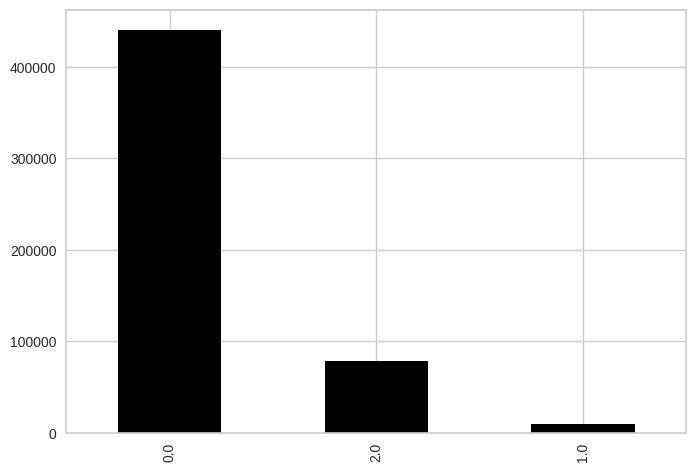

In [6]:
data['Diabetes_012'].value_counts().plot(kind='bar', color='black')

## Selecting Outcomes of Interest

We can see that we have quite an unbalanced dataset. However, because these samples are not evenly distributed in our population, we will leverage different approaches later in our modeling to accommodate for this imbalance.

In [7]:
data.groupby(['Diabetes_012']).size()

Diabetes_012
0.0    440607
1.0      9930
2.0     78257
dtype: int64

In [8]:
# select 12328 samples from healthy population
# remove diabetes class entirely

data = data[(data.Diabetes_012 != 0)]

data.groupby(['Diabetes_012']).size()

Diabetes_012
1.0     9930
2.0    78257
dtype: int64

In [9]:
data['Diabetes_012'] = data['Diabetes_012'].replace({2:0})

## Continuous Numerical Predictors

We have 1 continuous numerical predictor - BMI. 

### BMI

<AxesSubplot: title={'center': 'BMI'}, ylabel='Frequency'>

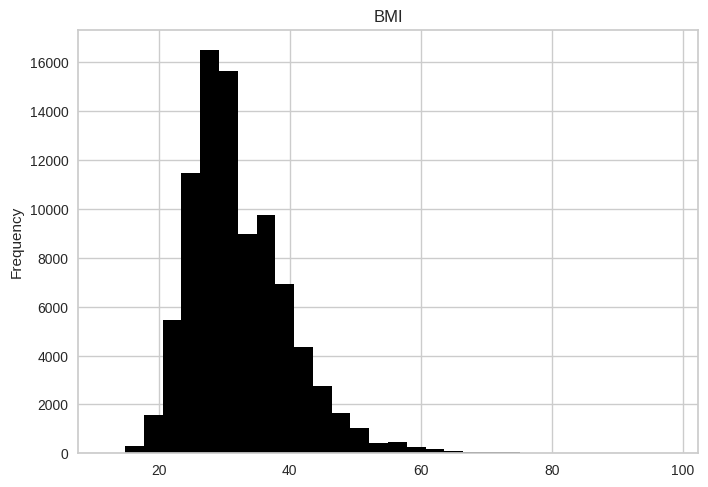

In [10]:
data['BMI'].plot(kind='hist', color='black',bins=30, title='BMI')

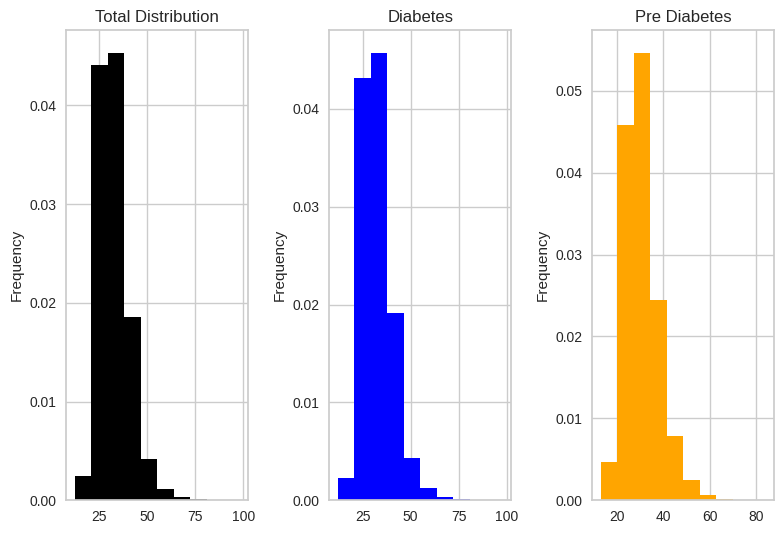

In [11]:
var = 'BMI'

fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Pre Diabetes")
plt.tight_layout()

In [12]:
data[var].groupby(data['Diabetes_012']).describe()

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,,,,,,,,
0.0,78257.0,32.522254,7.780586,12.0,27.0,31.0,37.0,98.0
1.0,9930.0,30.932528,7.253234,13.0,26.0,30.0,35.0,84.0


In [13]:
# One-Way ANOVA - Test of Variance Between Groups
diab = data.query('Diabetes_012 == 0')[var]
prediab = data.query('Diabetes_012 == 1')[var]

stats.f_oneway(diab, prediab)

F_onewayResult(statistic=373.3699219536954, pvalue=5.134944622235605e-83)

<AxesSubplot: xlabel='Diabetes_012', ylabel='BMI'>

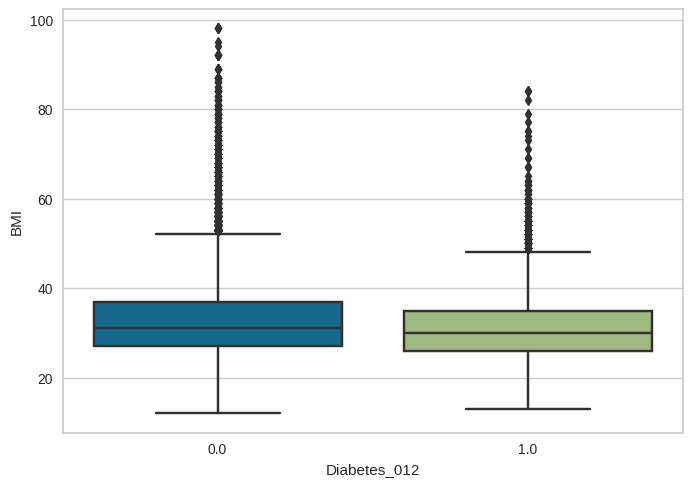

In [14]:
sn.boxplot(x='Diabetes_012', y=var, data=data)

Let's transform this variable - there are quite a few outliers which might make convergence difficult later. Let's transform this to mirror the categories used in the field.

In [15]:
data['BMI'].mask(data['BMI'] < 18.5, 0, inplace=True)
data['BMI'].mask((data['BMI'] >= 18.5) & (data['BMI'] <= 24.9), 1, inplace=True)
data['BMI'].mask((data['BMI'] >= 25) & (data['BMI'] <= 29.9), 2, inplace=True)
data['BMI'].mask((data['BMI'] >= 30) & (data['BMI'] <= 34.9), 3, inplace=True)
data['BMI'].mask((data['BMI'] >= 35) & (data['BMI'] <= 39.9), 4, inplace=True)
data['BMI'].mask((data['BMI'] >= 40), 5, inplace=True)

Text(0.5, 1.0, 'Pre Diabetes')

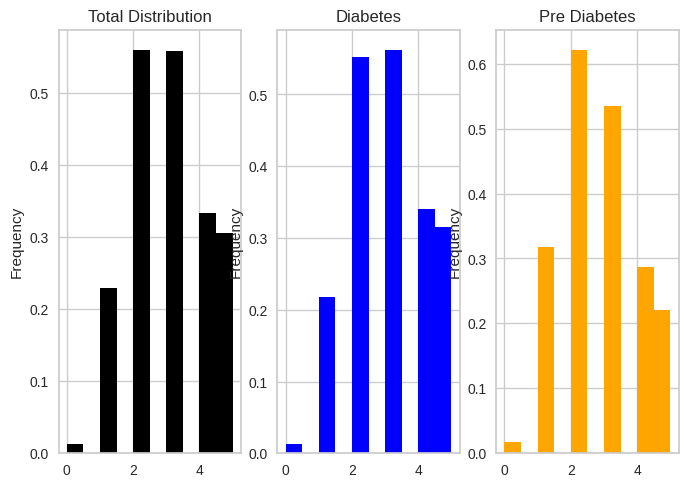

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Pre Diabetes")


## Categorical Predictors
The rest of our predictors are categorical or binary. 
This requires a different approach than what we can do with a continous valued predictor.


HighBP

HighChol

CholCheck

BMI

Smoker

Stroke

HeartDiseaseorAttack

PhysActivity

Fruits

Veggies

HvyAlcoholConsump

AnyHealthcare

NoDocbcCost

GenHlth

DiffWalk

Sex 

Age    

Education

Income                  


In [17]:
def var_hist(var, data,fig,w,h):
    
    plt.tight_layout()
    gs = fig.add_gridspec(5,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])
    ax6 = fig.add_subplot(gs[3, :])
    ax7 = fig.add_subplot(gs[4, 0])
    ax8 = fig.add_subplot(gs[4, 1])
    plt.tight_layout()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    fig.suptitle(var, fontsize=14)
    data[var].plot(ax=ax1,kind='hist',color='black', density=True).set_title("Total Distribution")
    data.query('Diabetes_012 == 0')[var].plot(ax=ax2,kind='hist',color='blue', density=True).set_title("Diabetes")
    data.query('Diabetes_012 == 1')[var].plot(ax=ax3,kind='hist',color='orange', density=True).set_title("Pre Diabetes")
    desc = data[var].groupby(data['Diabetes_012']).describe()
    desc.insert(0, 'Class', desc.index)
    table = desc 
    cell_text = []
    for row in range(len(table)):
        cell_text.append(round(table.iloc[row],2))
    table = ax5.table(cellText=cell_text, colLabels=table.columns, loc=ax5)
    ax5.axis('off')
    table.set_fontsize(10)
    ax5.set_title(var + " - descriptive statistics")
    plt.tight_layout()
    crosstab = pd.crosstab(data[var],data['Diabetes_012'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    ct_data = {'Chi-square: ':  [chi2],
            'p-value: ': [p],
            'DOF: ': [dof]}
    df = pd.DataFrame(ct_data)
    cell_text_chi = []
    for row in range(len(df)):
        cell_text_chi.append(df.iloc[row])
    table_chi = ax6.table(cellText=cell_text_chi,colLabels=df.columns, loc=ax6)
    ax6.axis('off')
    table_chi.set_fontsize(10)
    ax6.set_title(var + " - Chi Square Test")
    plt.tight_layout()
    act = pd.DataFrame(crosstab)
    act_cell_text = []
    for row in range(len(act)):
        act_cell_text.append(act.iloc[row])
    table_act = ax7.table(cellText=act_cell_text,colLabels=act.columns, loc=ax7)
    ax7.axis('tight')
    ax7.axis('off')
    table_act.set_fontsize(10)
    ax7.set_title("Chi Square - Actual Frequencies")
    plt.tight_layout()
    exp = pd.DataFrame(expected)
    exp_cell_text = []
    for row in range(len(exp)):
        exp_cell_text.append(exp.iloc[row])
    table_exp = ax8.table(cellText=exp_cell_text,colLabels=exp.columns, loc=ax8)
    ax8.axis('off')
    table_exp.set_fontsize(10)
    ax8.set_title("Chi Square - Expected Frequencies")

In [18]:
from sklearn.feature_selection import chi2

X = data.drop('Diabetes_012',axis=1)
y = data['Diabetes_012']

chi_scores = chi2(X,y)
chi_scores

(array([2.10850088e+02, 7.00571066e-01, 1.13948122e+02, 7.25805897e+01,
        1.10908356e+01, 1.11718405e+02, 2.90099244e+02, 9.50994374e+01,
        5.58105200e+01, 2.37291550e+01, 4.32600850e+02, 7.98996089e+00,
        4.04872224e+01, 2.54626836e+00, 1.46526959e+01, 2.95049137e+02,
        8.40775251e+02]),
 array([8.96194848e-048, 4.02591874e-001, 1.33762701e-026, 1.60348436e-017,
        8.67553830e-004, 4.11841673e-026, 4.73077129e-065, 1.81058177e-022,
        7.98033603e-014, 1.10889895e-006, 4.41384675e-096, 4.70374311e-003,
        1.97906051e-010, 1.10555098e-001, 1.29249642e-004, 3.94845397e-066,
        7.36307079e-185]))

In [19]:
p_values = pd.DataFrame(chi_scores[1],index = X.columns)
print(p_values)
print("p-value greater than 0.05:")
for p in p_values.index:
    val = p_values.loc[p]
    if val.loc[0] > 0.05:
        print(val.name)

                           0
BMI             8.961948e-48
Smoker          4.025919e-01
Stroke          1.337627e-26
PhysActivity    1.603484e-17
AnyHealthcare   8.675538e-04
NoDocbcCost     4.118417e-26
GenHlth         4.730771e-65
MentHlth        1.810582e-22
PhysHlth        7.980336e-14
Sex             1.108899e-06
Age             4.413847e-96
Education       4.703743e-03
Income          1.979061e-10
Marital         1.105551e-01
PoorHlth        1.292496e-04
HeartAttack     3.948454e-66
HighBP         7.363071e-185
p-value greater than 0.05:
Smoker
Marital


In [20]:
data = data.drop(columns=['Smoker','Marital'],axis=1)
var_list = list(data.drop('Diabetes_012', axis=1).columns)
var_idx = -1

### BMI

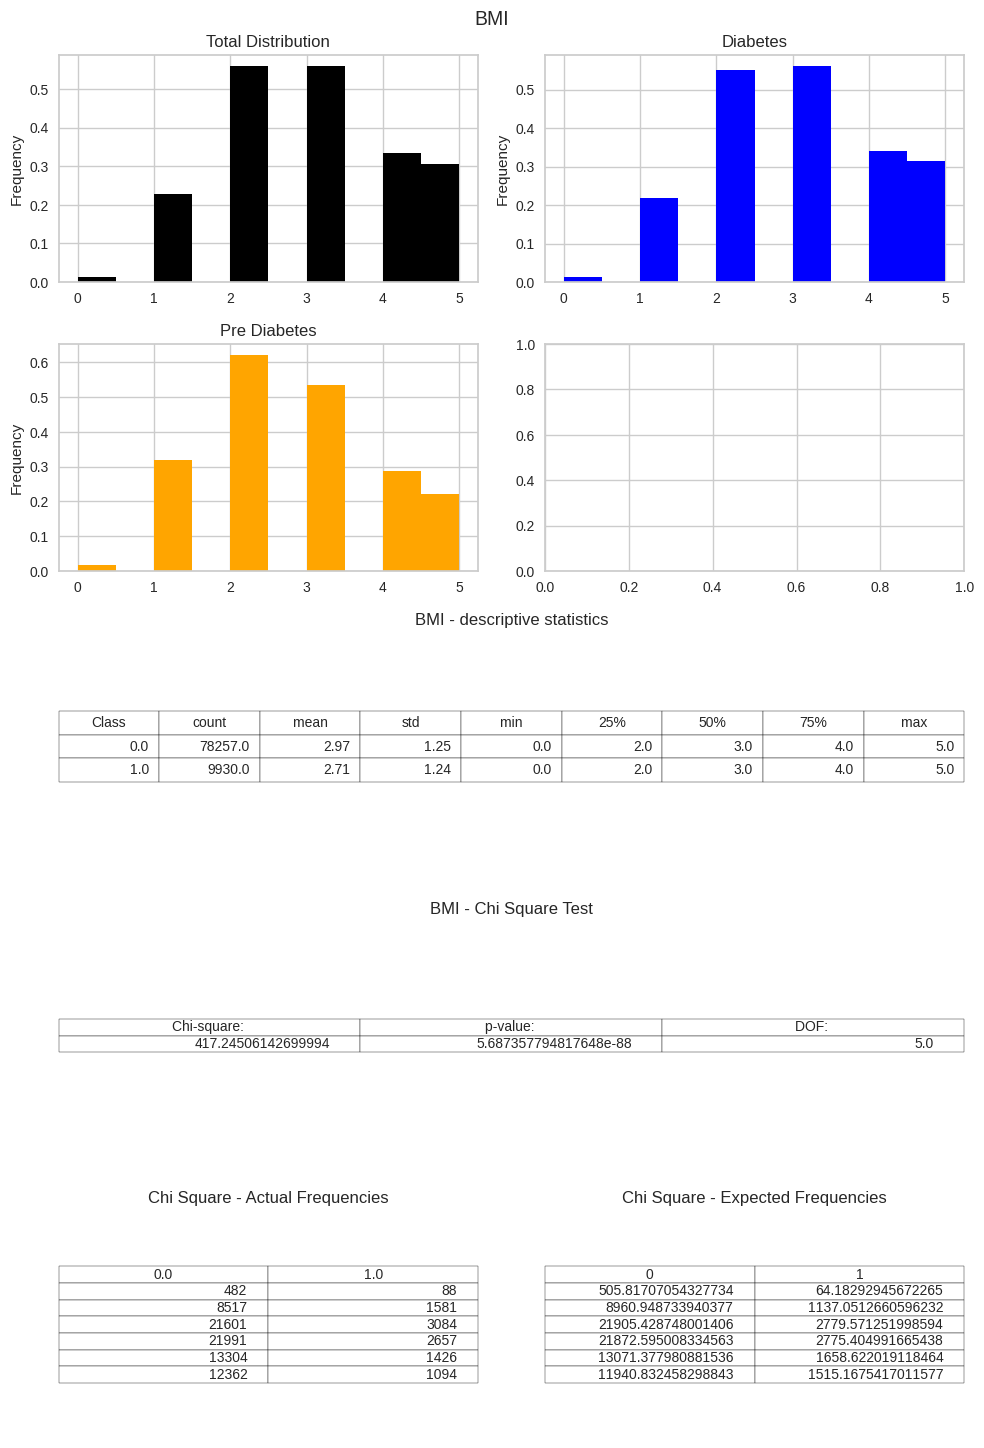

In [21]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Stroke

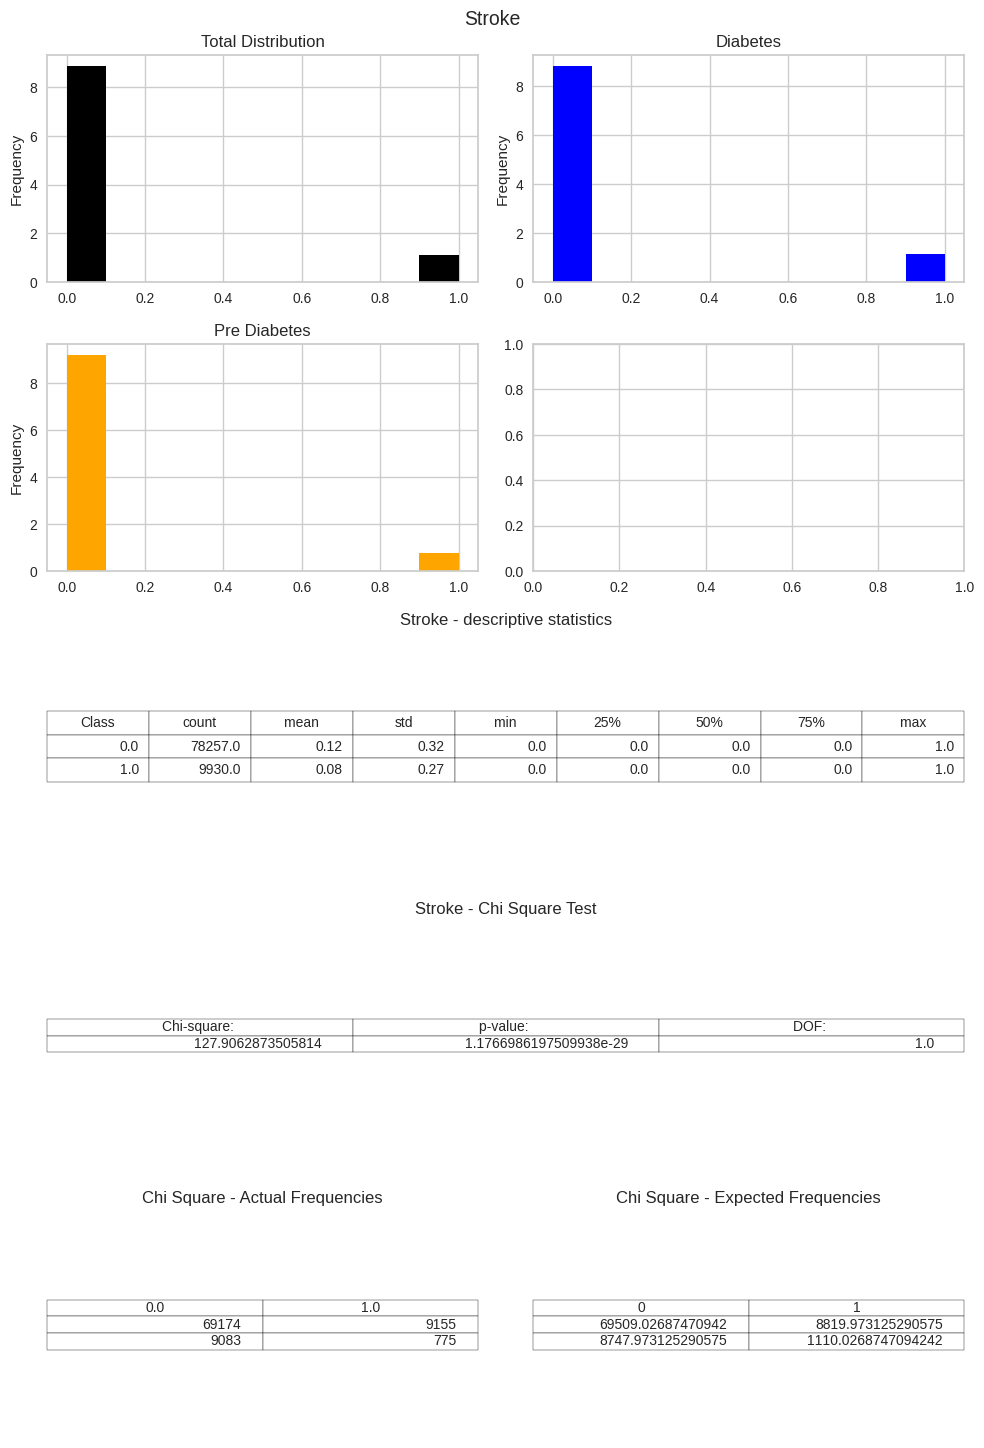

In [22]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Activity

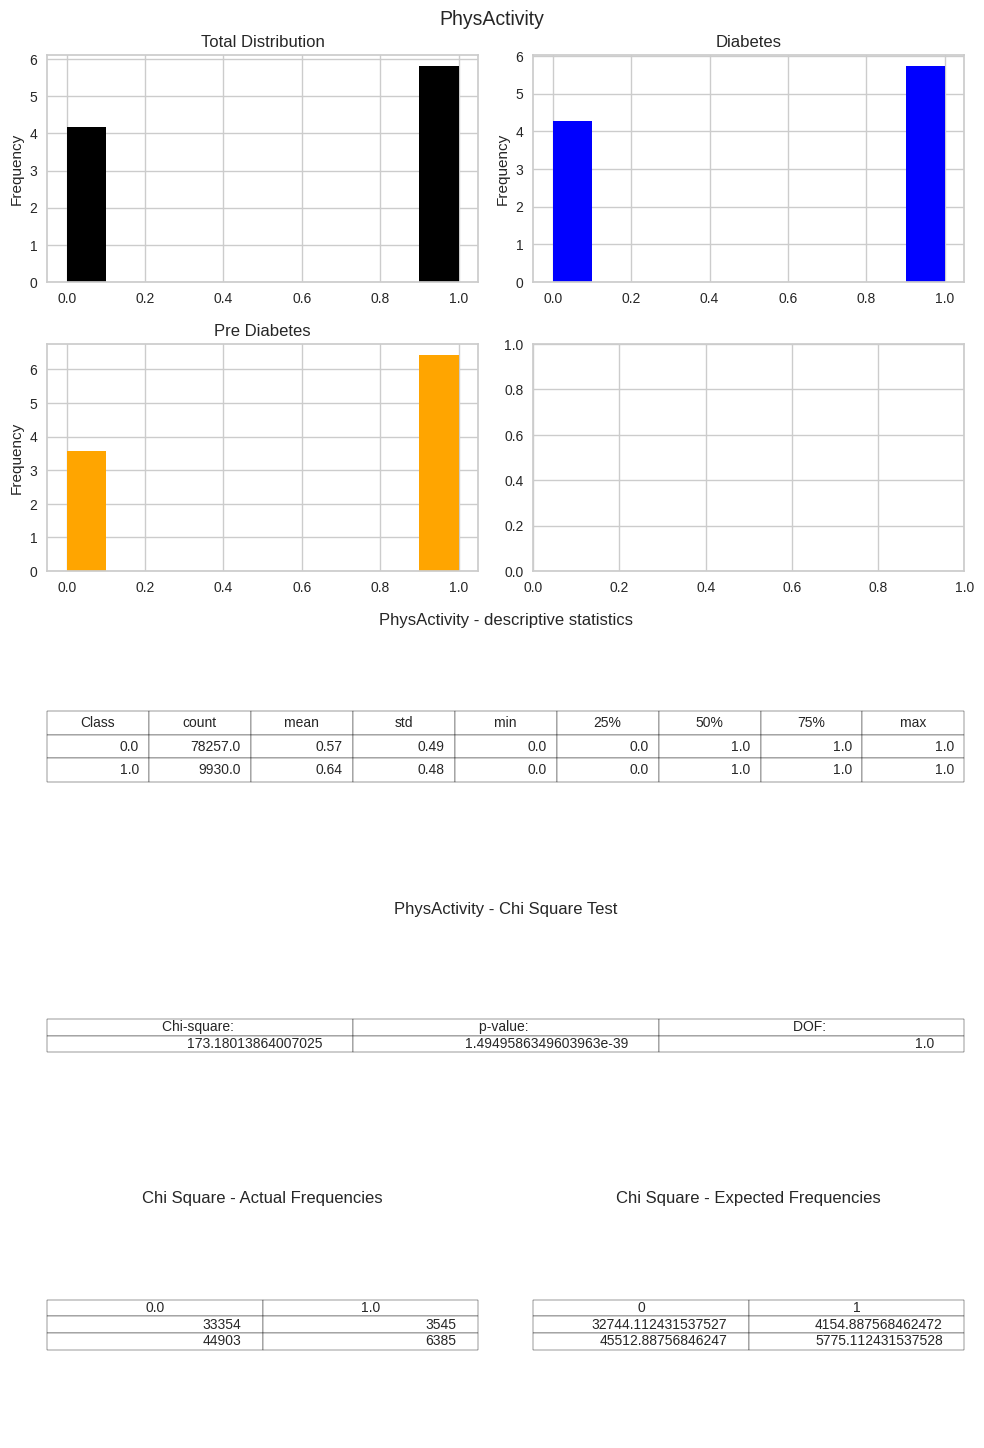

In [23]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Any Healthcare

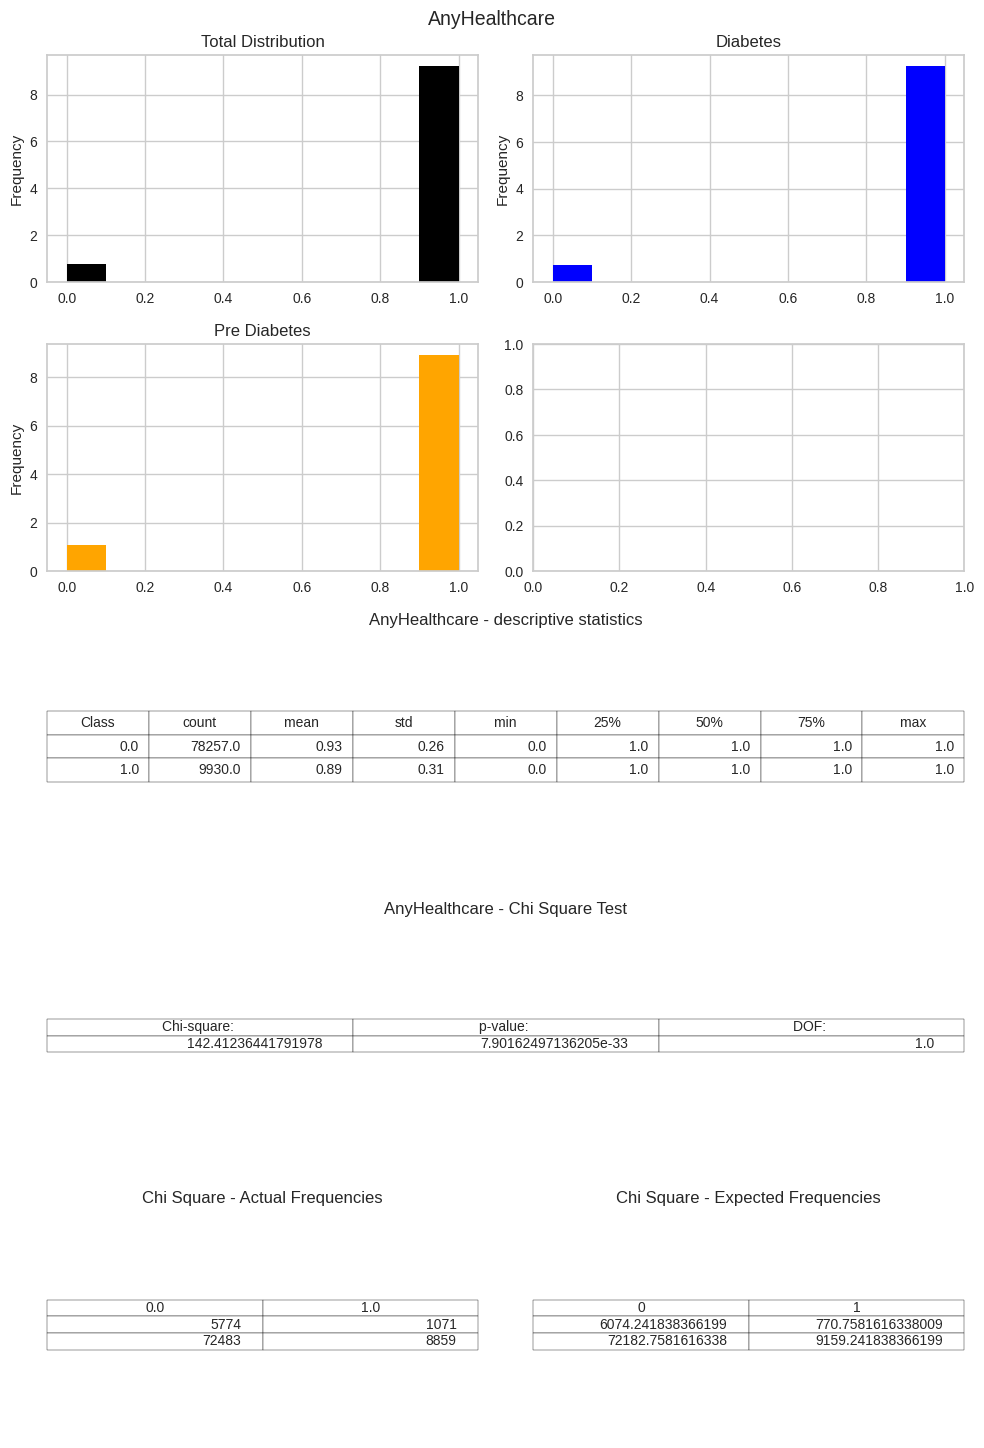

In [24]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### No Doctor Because of Cost

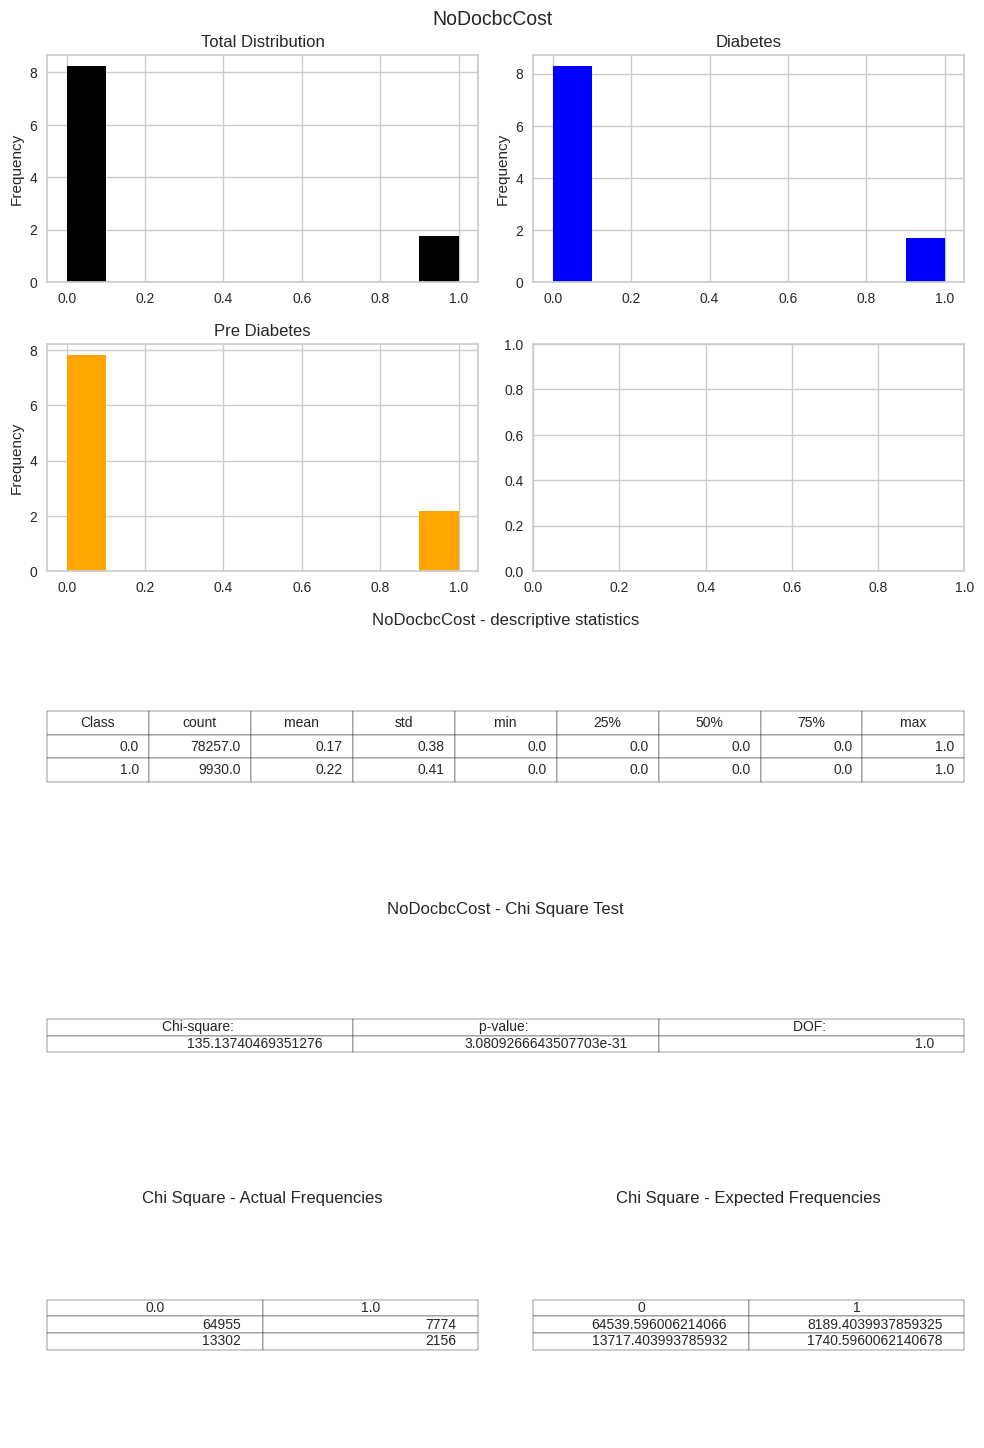

In [25]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### General Health

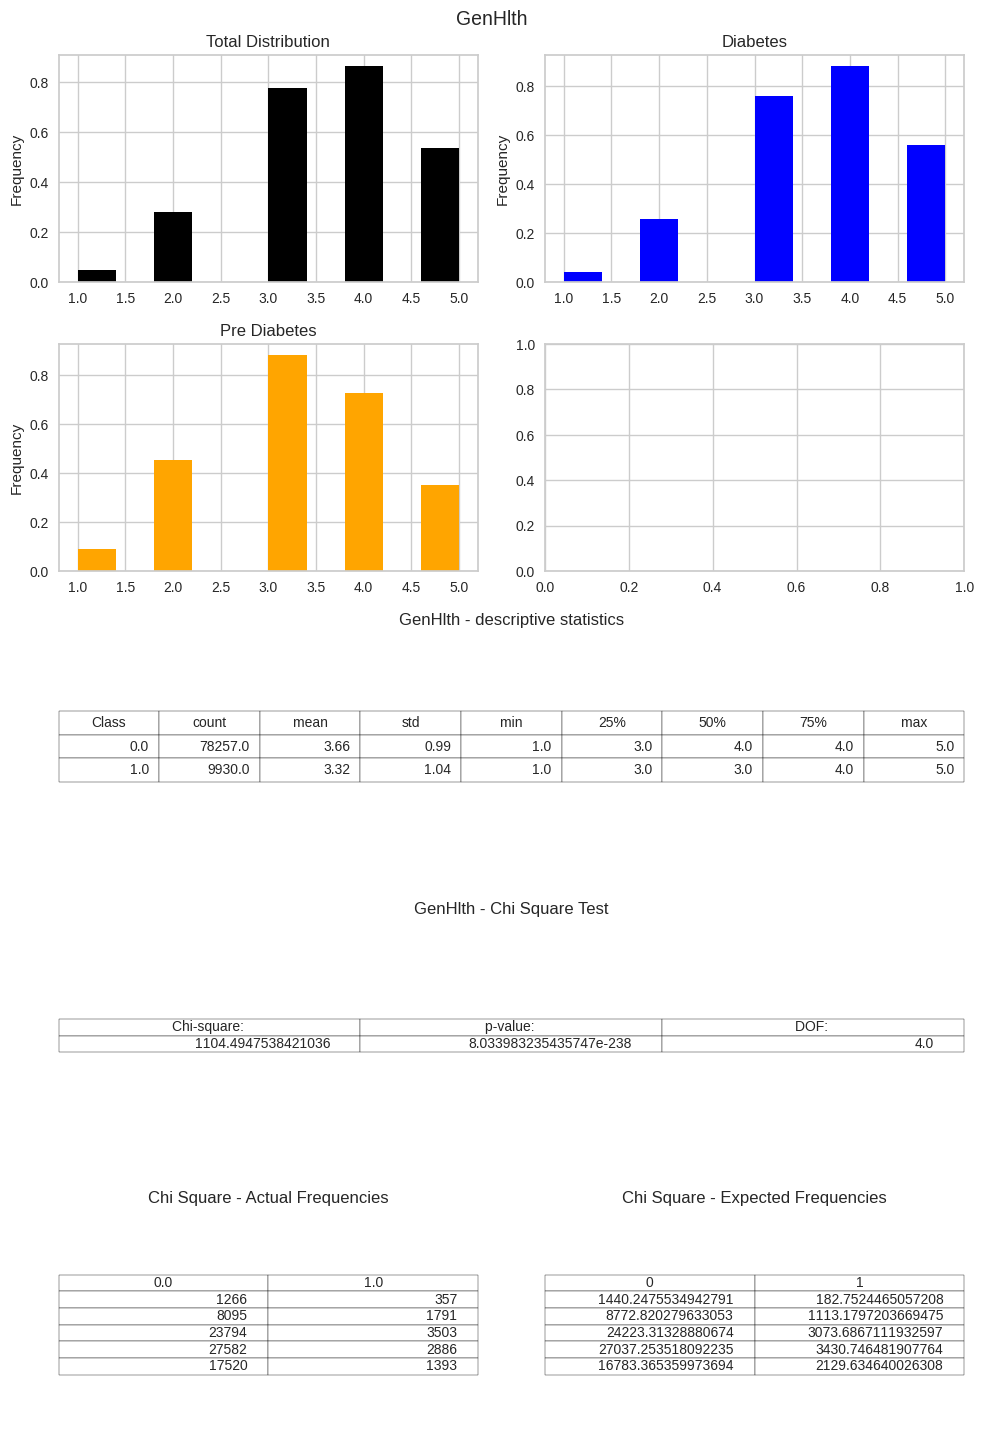

In [26]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Mental Health

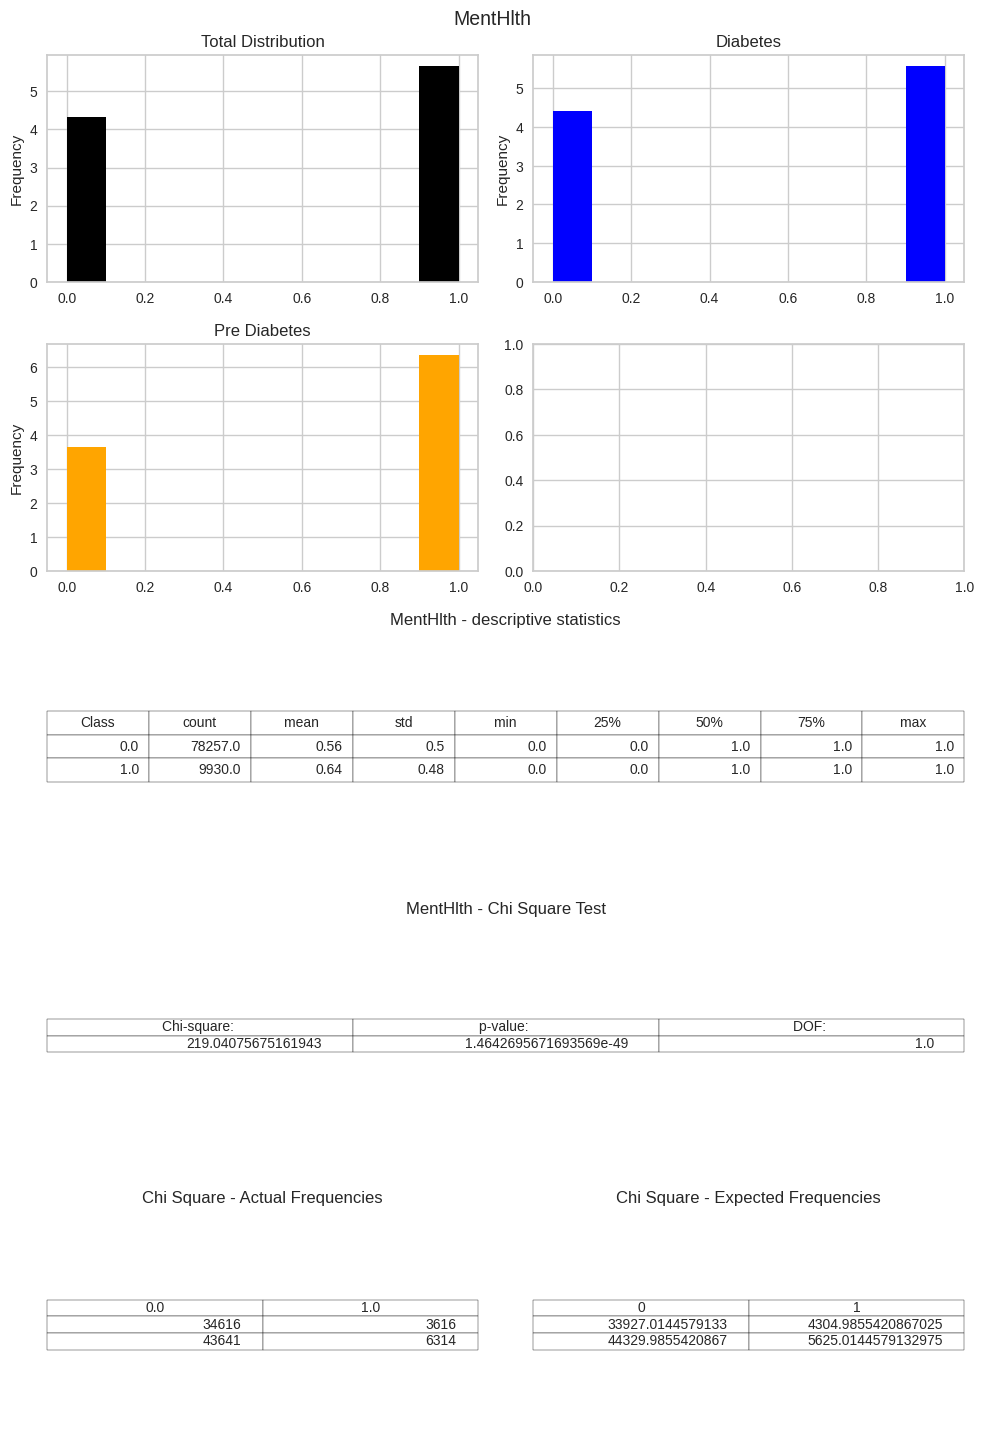

In [27]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Health

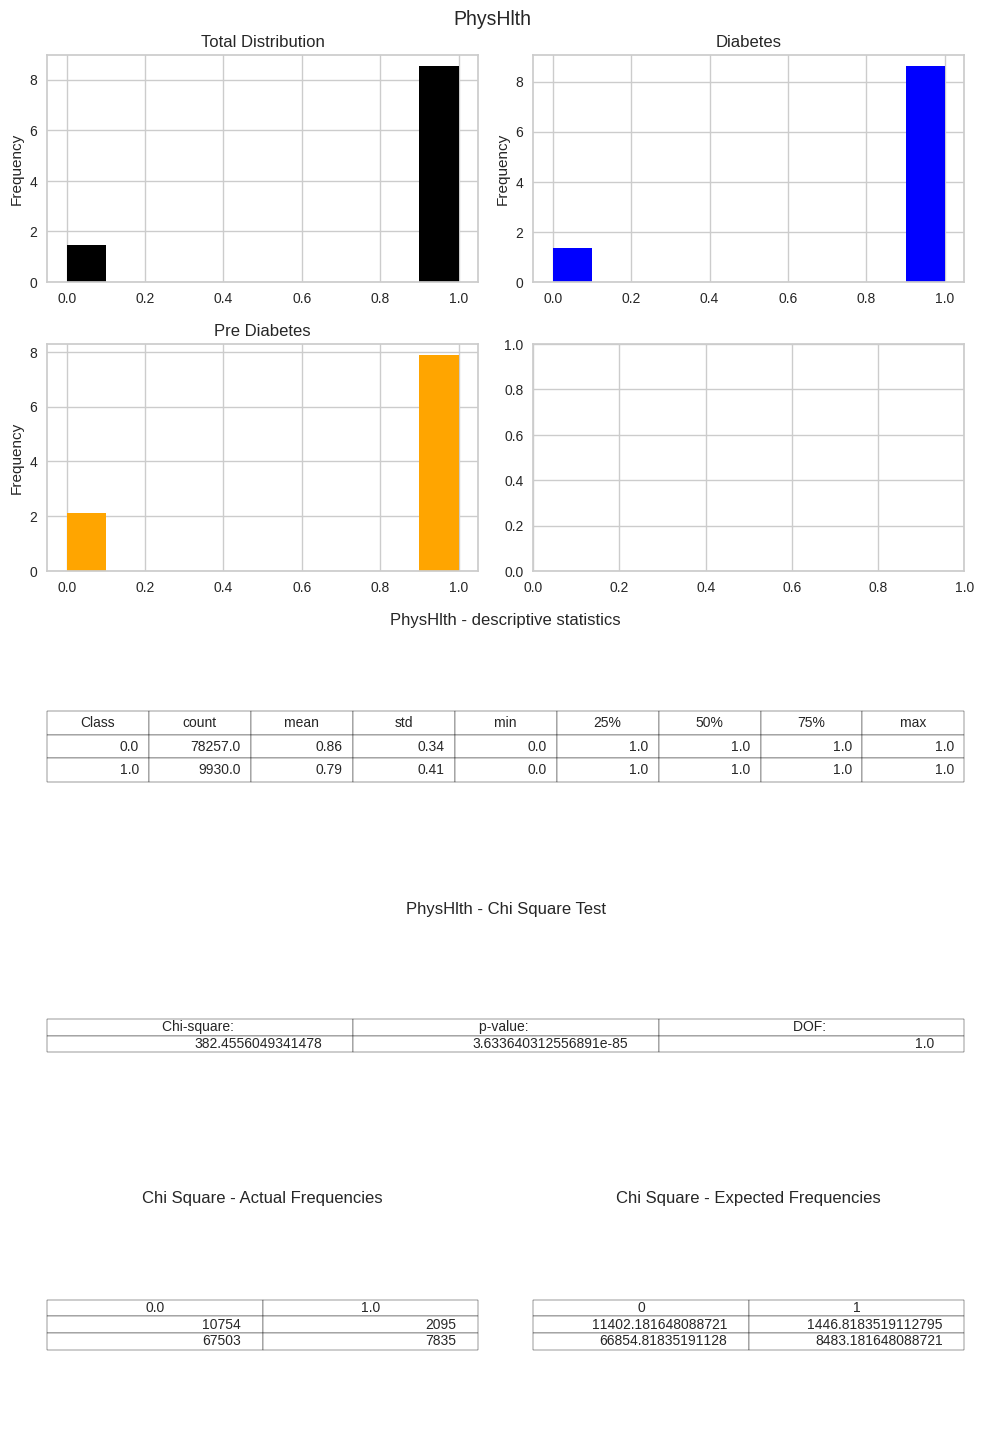

In [28]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Sex

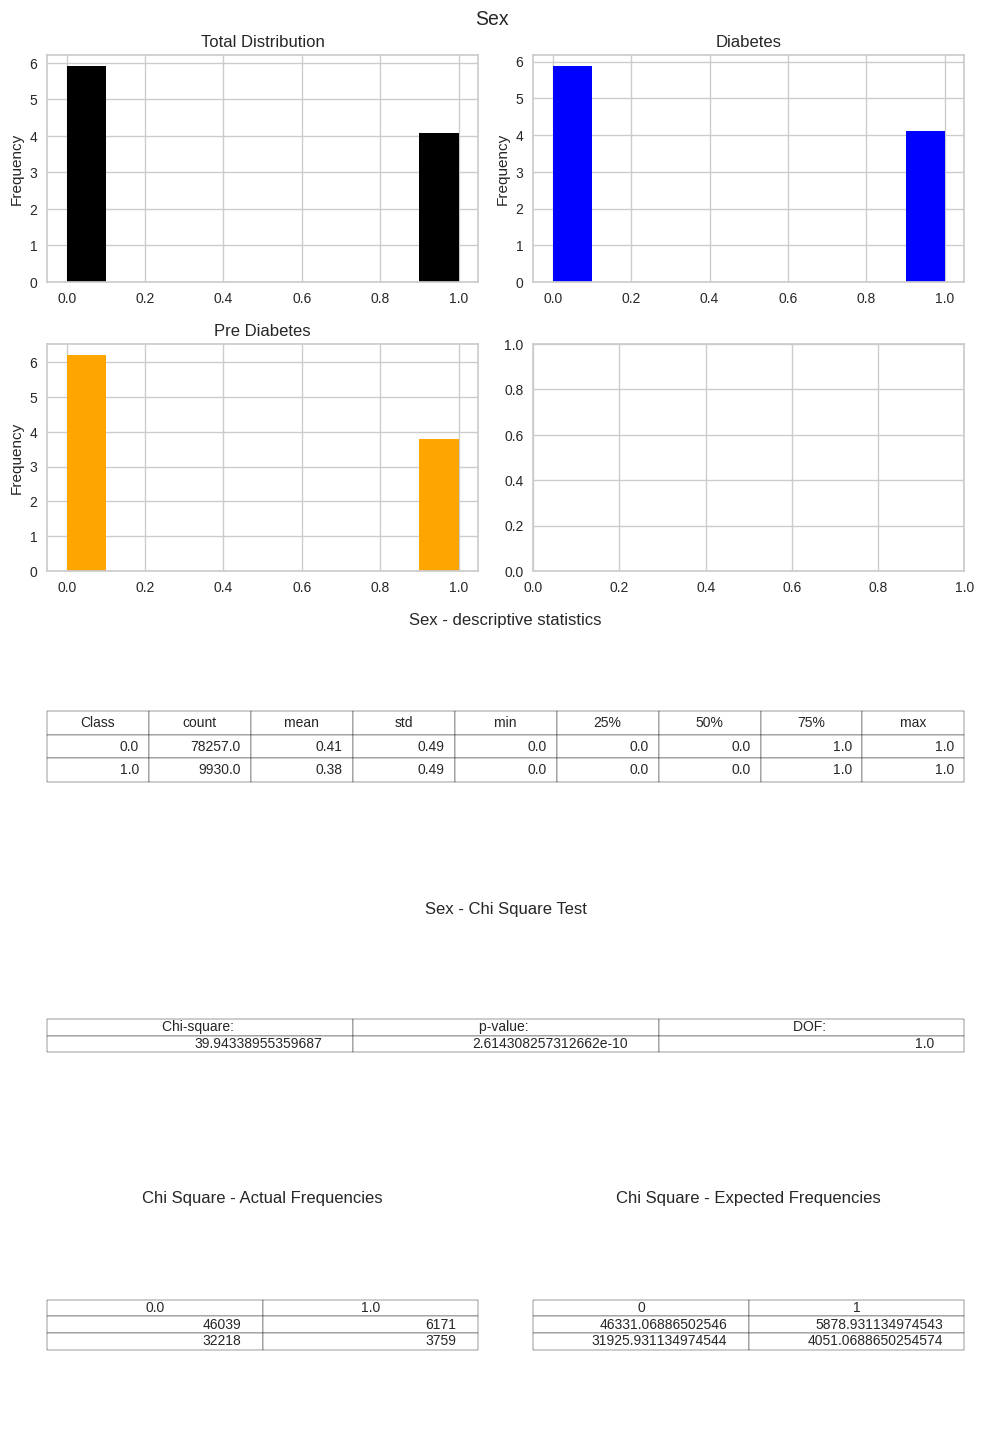

In [29]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Age

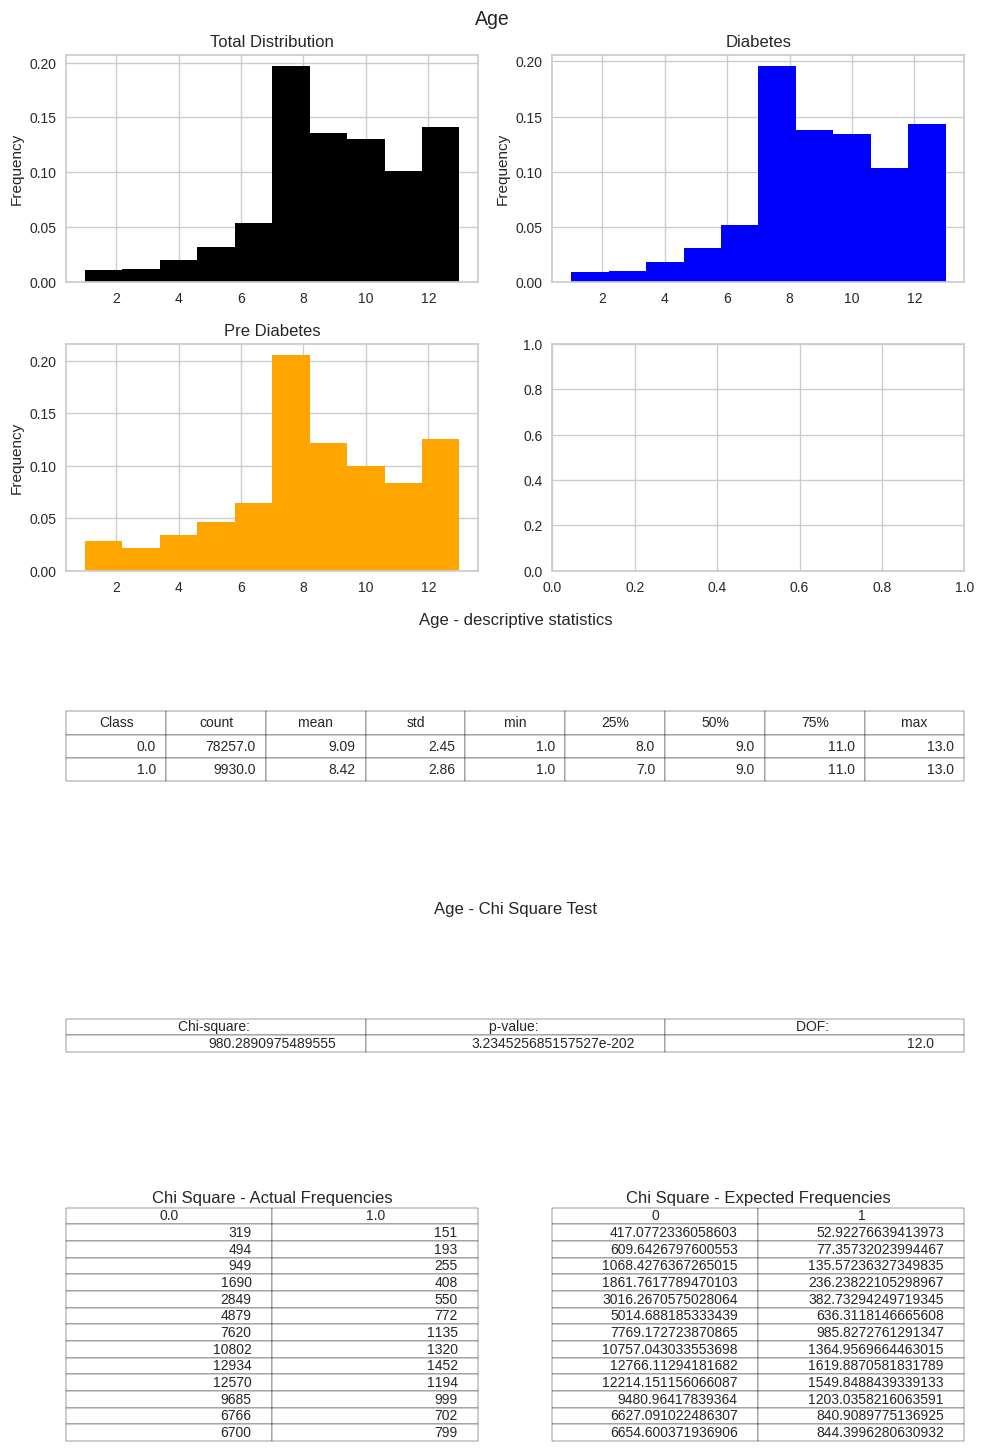

In [30]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Education

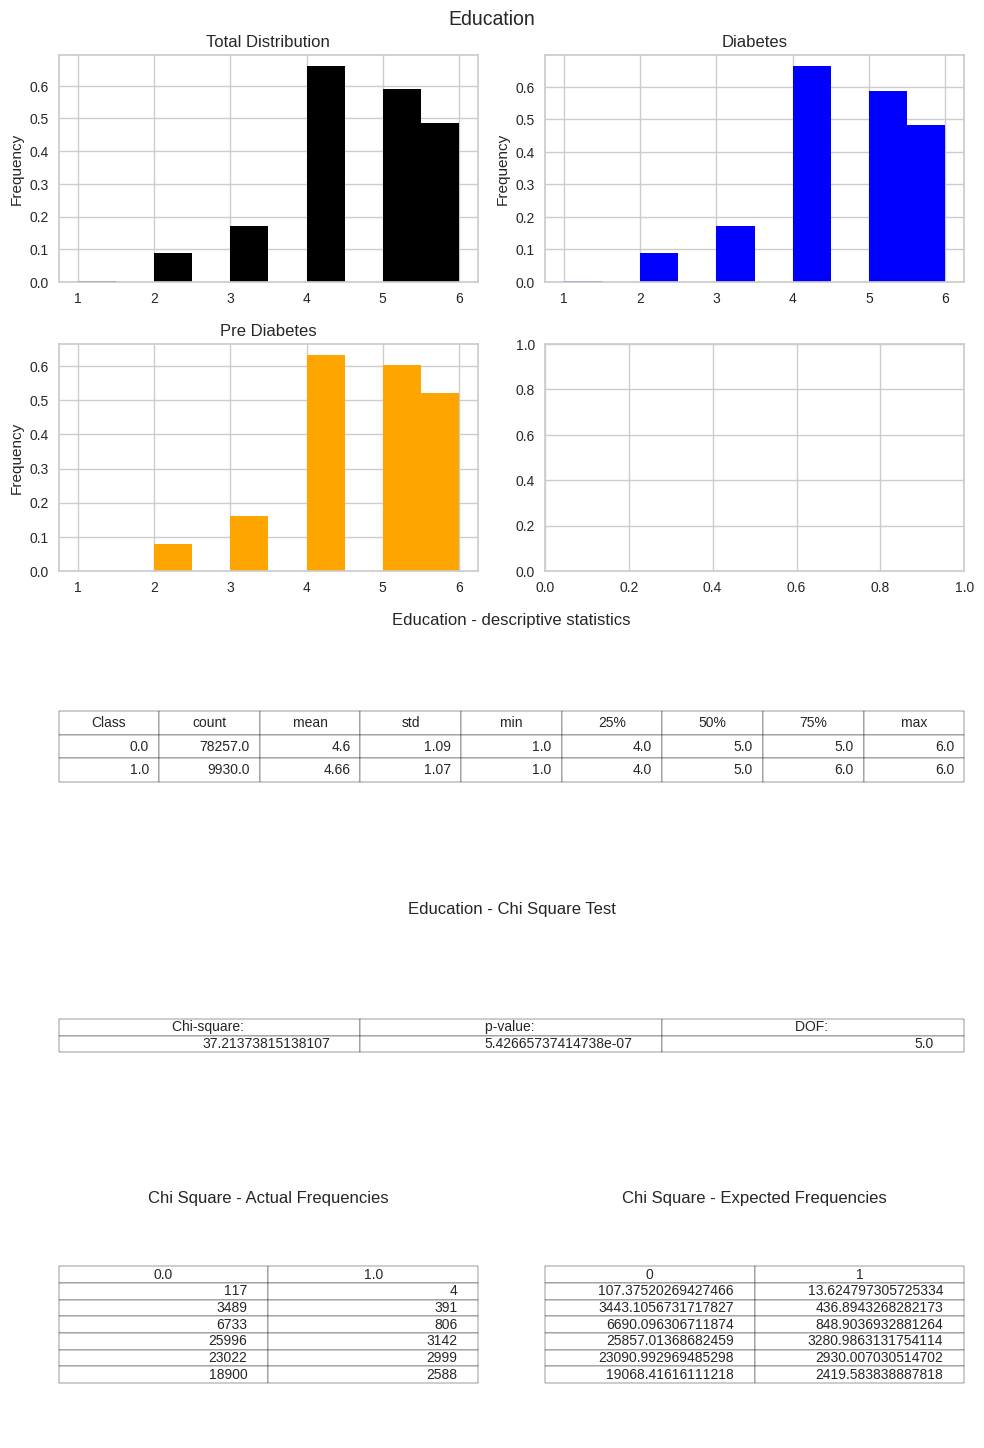

In [31]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Income

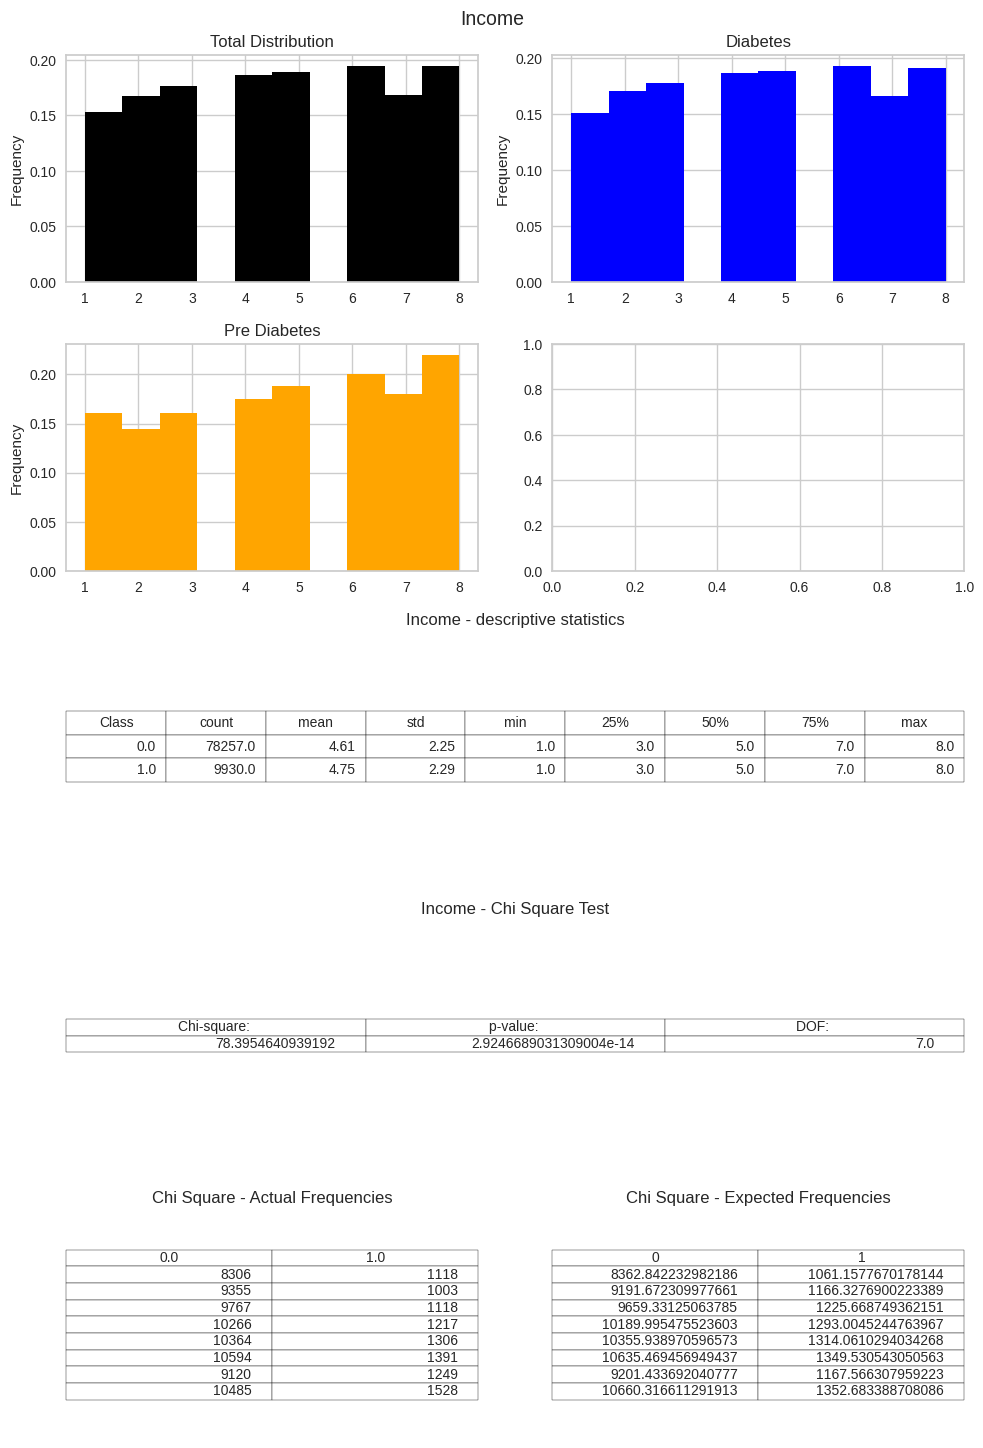

In [32]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Poor Health

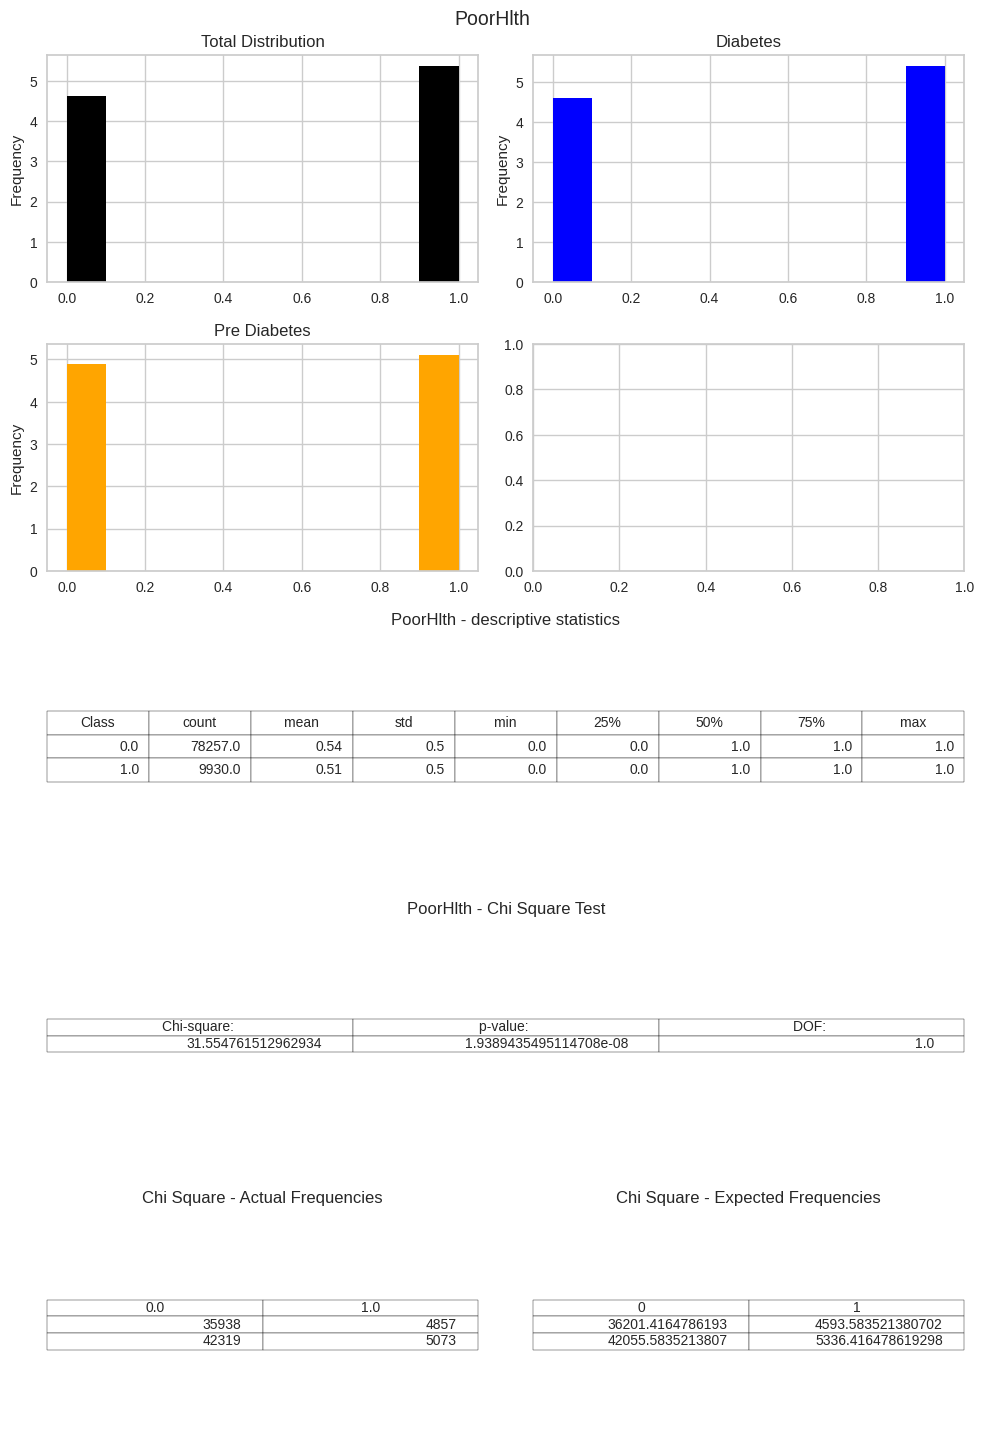

In [33]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Heart Attack

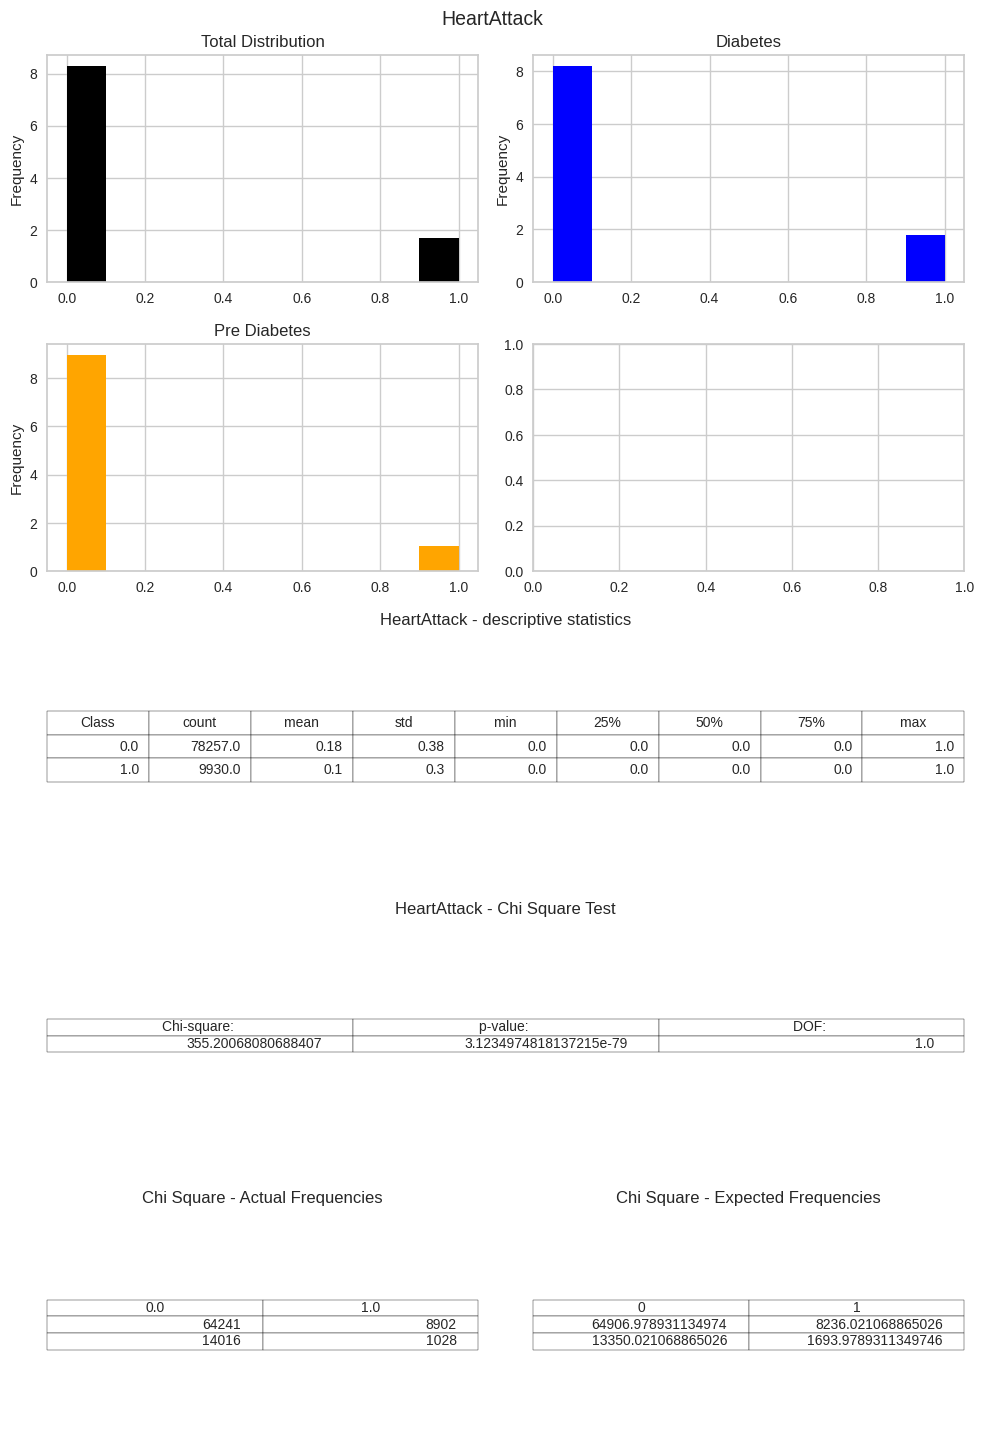

In [34]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### High Blood Pressure

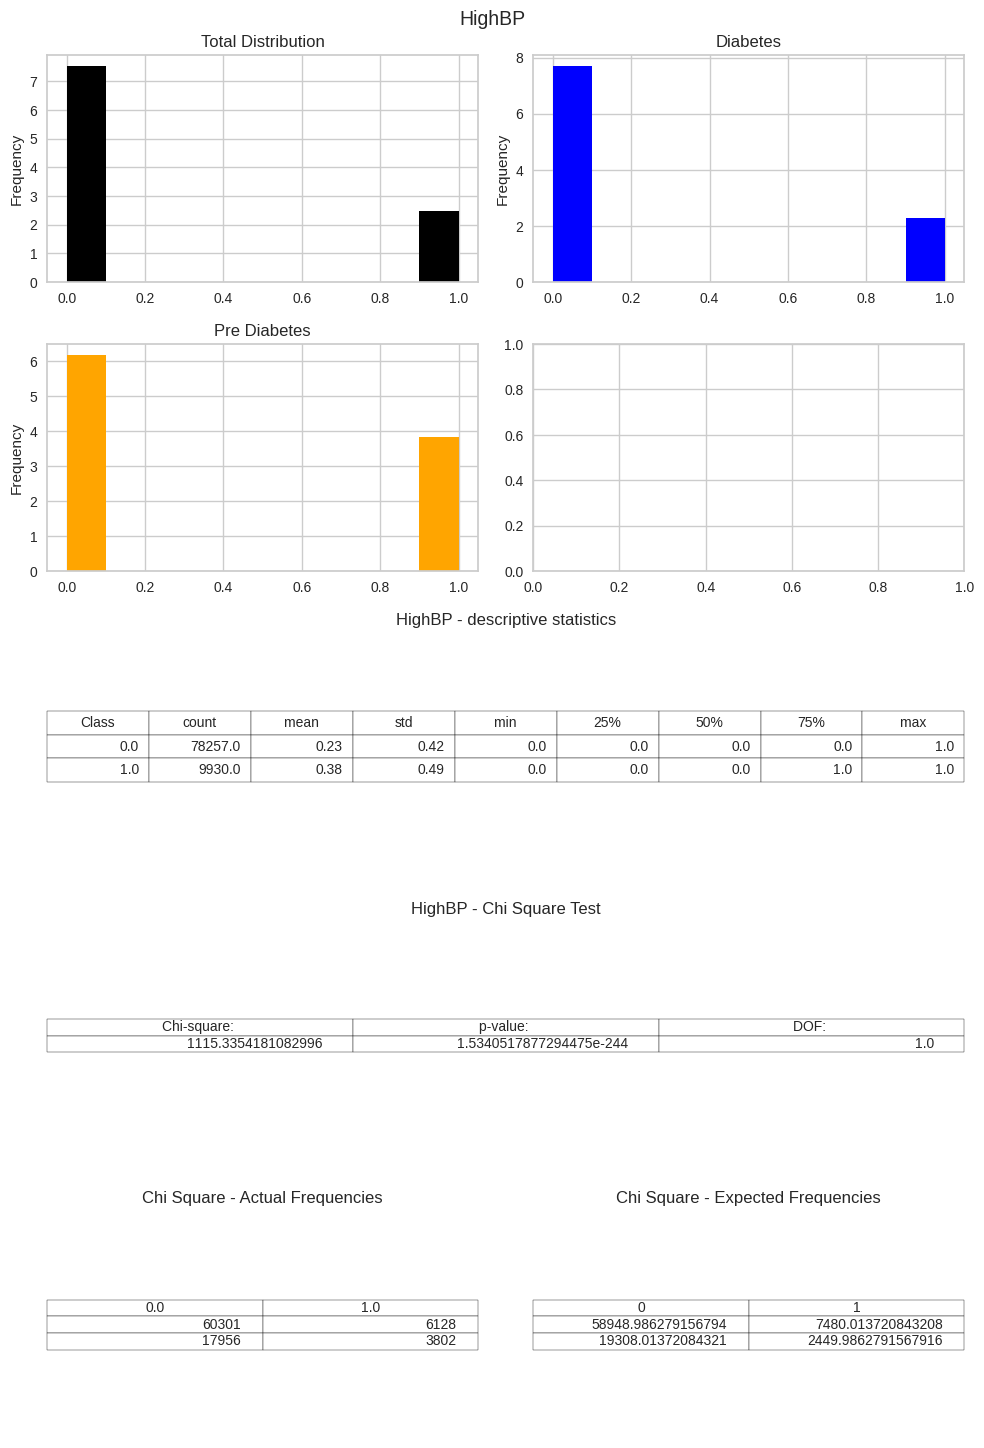

In [35]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

## Collinearity & Variance

When using regression techniques, we make the statistical assumption that are predictors are independent, or not related. Thus, it is important that we drop any strongly intercorrelated features from our analysis. 

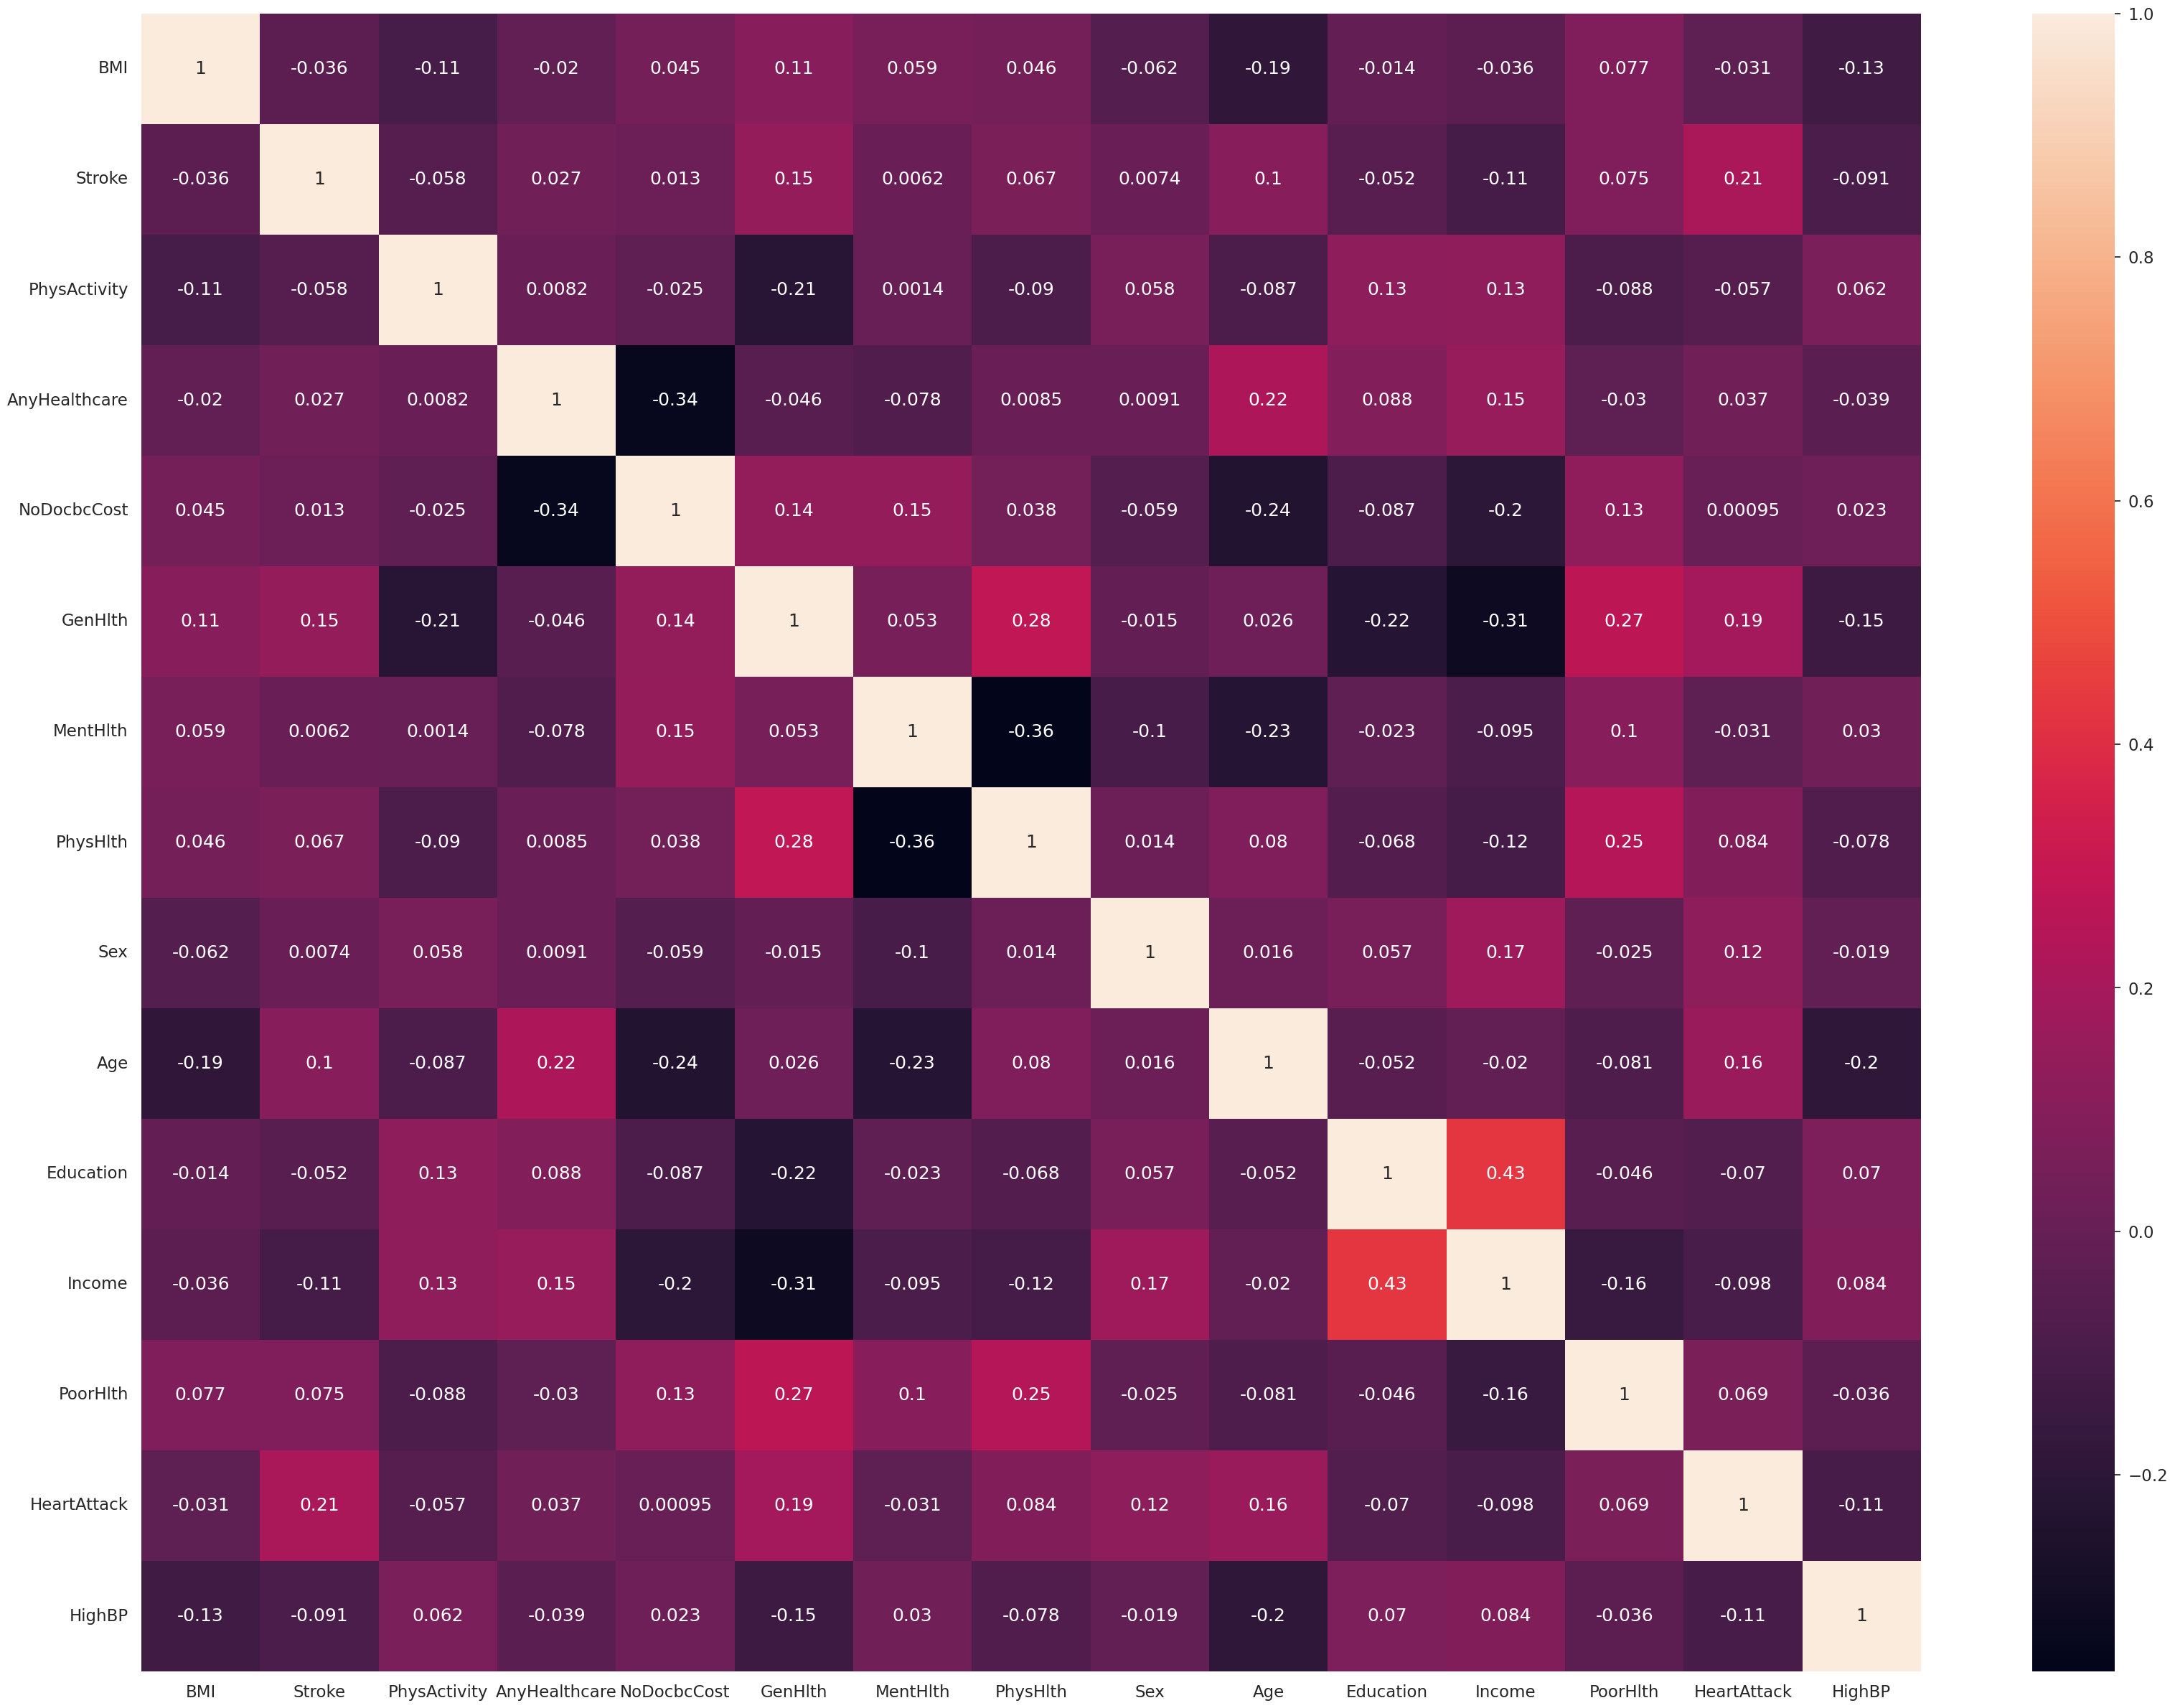

In [36]:
data_full = data
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are actually not many values that are strongly intercorrelated. Usually a strong correlation is considered to be 0.70 or greater. However, there are some variables that are moderately intercorrelated.

In [37]:
def vif(data_corr):
    drop_cols = []
    vif_flag = False
    while(vif_flag == False):
        vif = pd.DataFrame()
        vif["features"] = data_corr.columns
        vif["vif_factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
        vif = vif.sort_values(by=['vif_factor'], ascending=False)
        top_vif = vif.iloc[0]
        top_vif_name = top_vif['features']
        if(top_vif.loc['vif_factor'] > 5):
            drop_cols.append(top_vif_name)
            print(top_vif_name, ':', top_vif['vif_factor'])
            data_corr = data_corr.drop([top_vif_name],axis=1)
            continue
        else:
            vif_flag = True
            return vif, drop_cols

In [38]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif, drop_cols = vif(data_corr)

vif

Education : 19.558636046292563
GenHlth : 15.698833905867547
AnyHealthcare : 13.12445971443449
Age : 8.714076343714552
PhysHlth : 5.751555163555438


,features,vif_factor
0,BMI,4.331509
6,Income,4.263337
2,PhysActivity,2.267869
4,MentHlth,2.260254
7,PoorHlth,2.128726
5,Sex,1.760552
9,HighBP,1.342188
8,HeartAttack,1.281895
3,NoDocbcCost,1.277729
1,Stroke,1.178747


In [39]:
data = data.drop(columns=drop_cols)

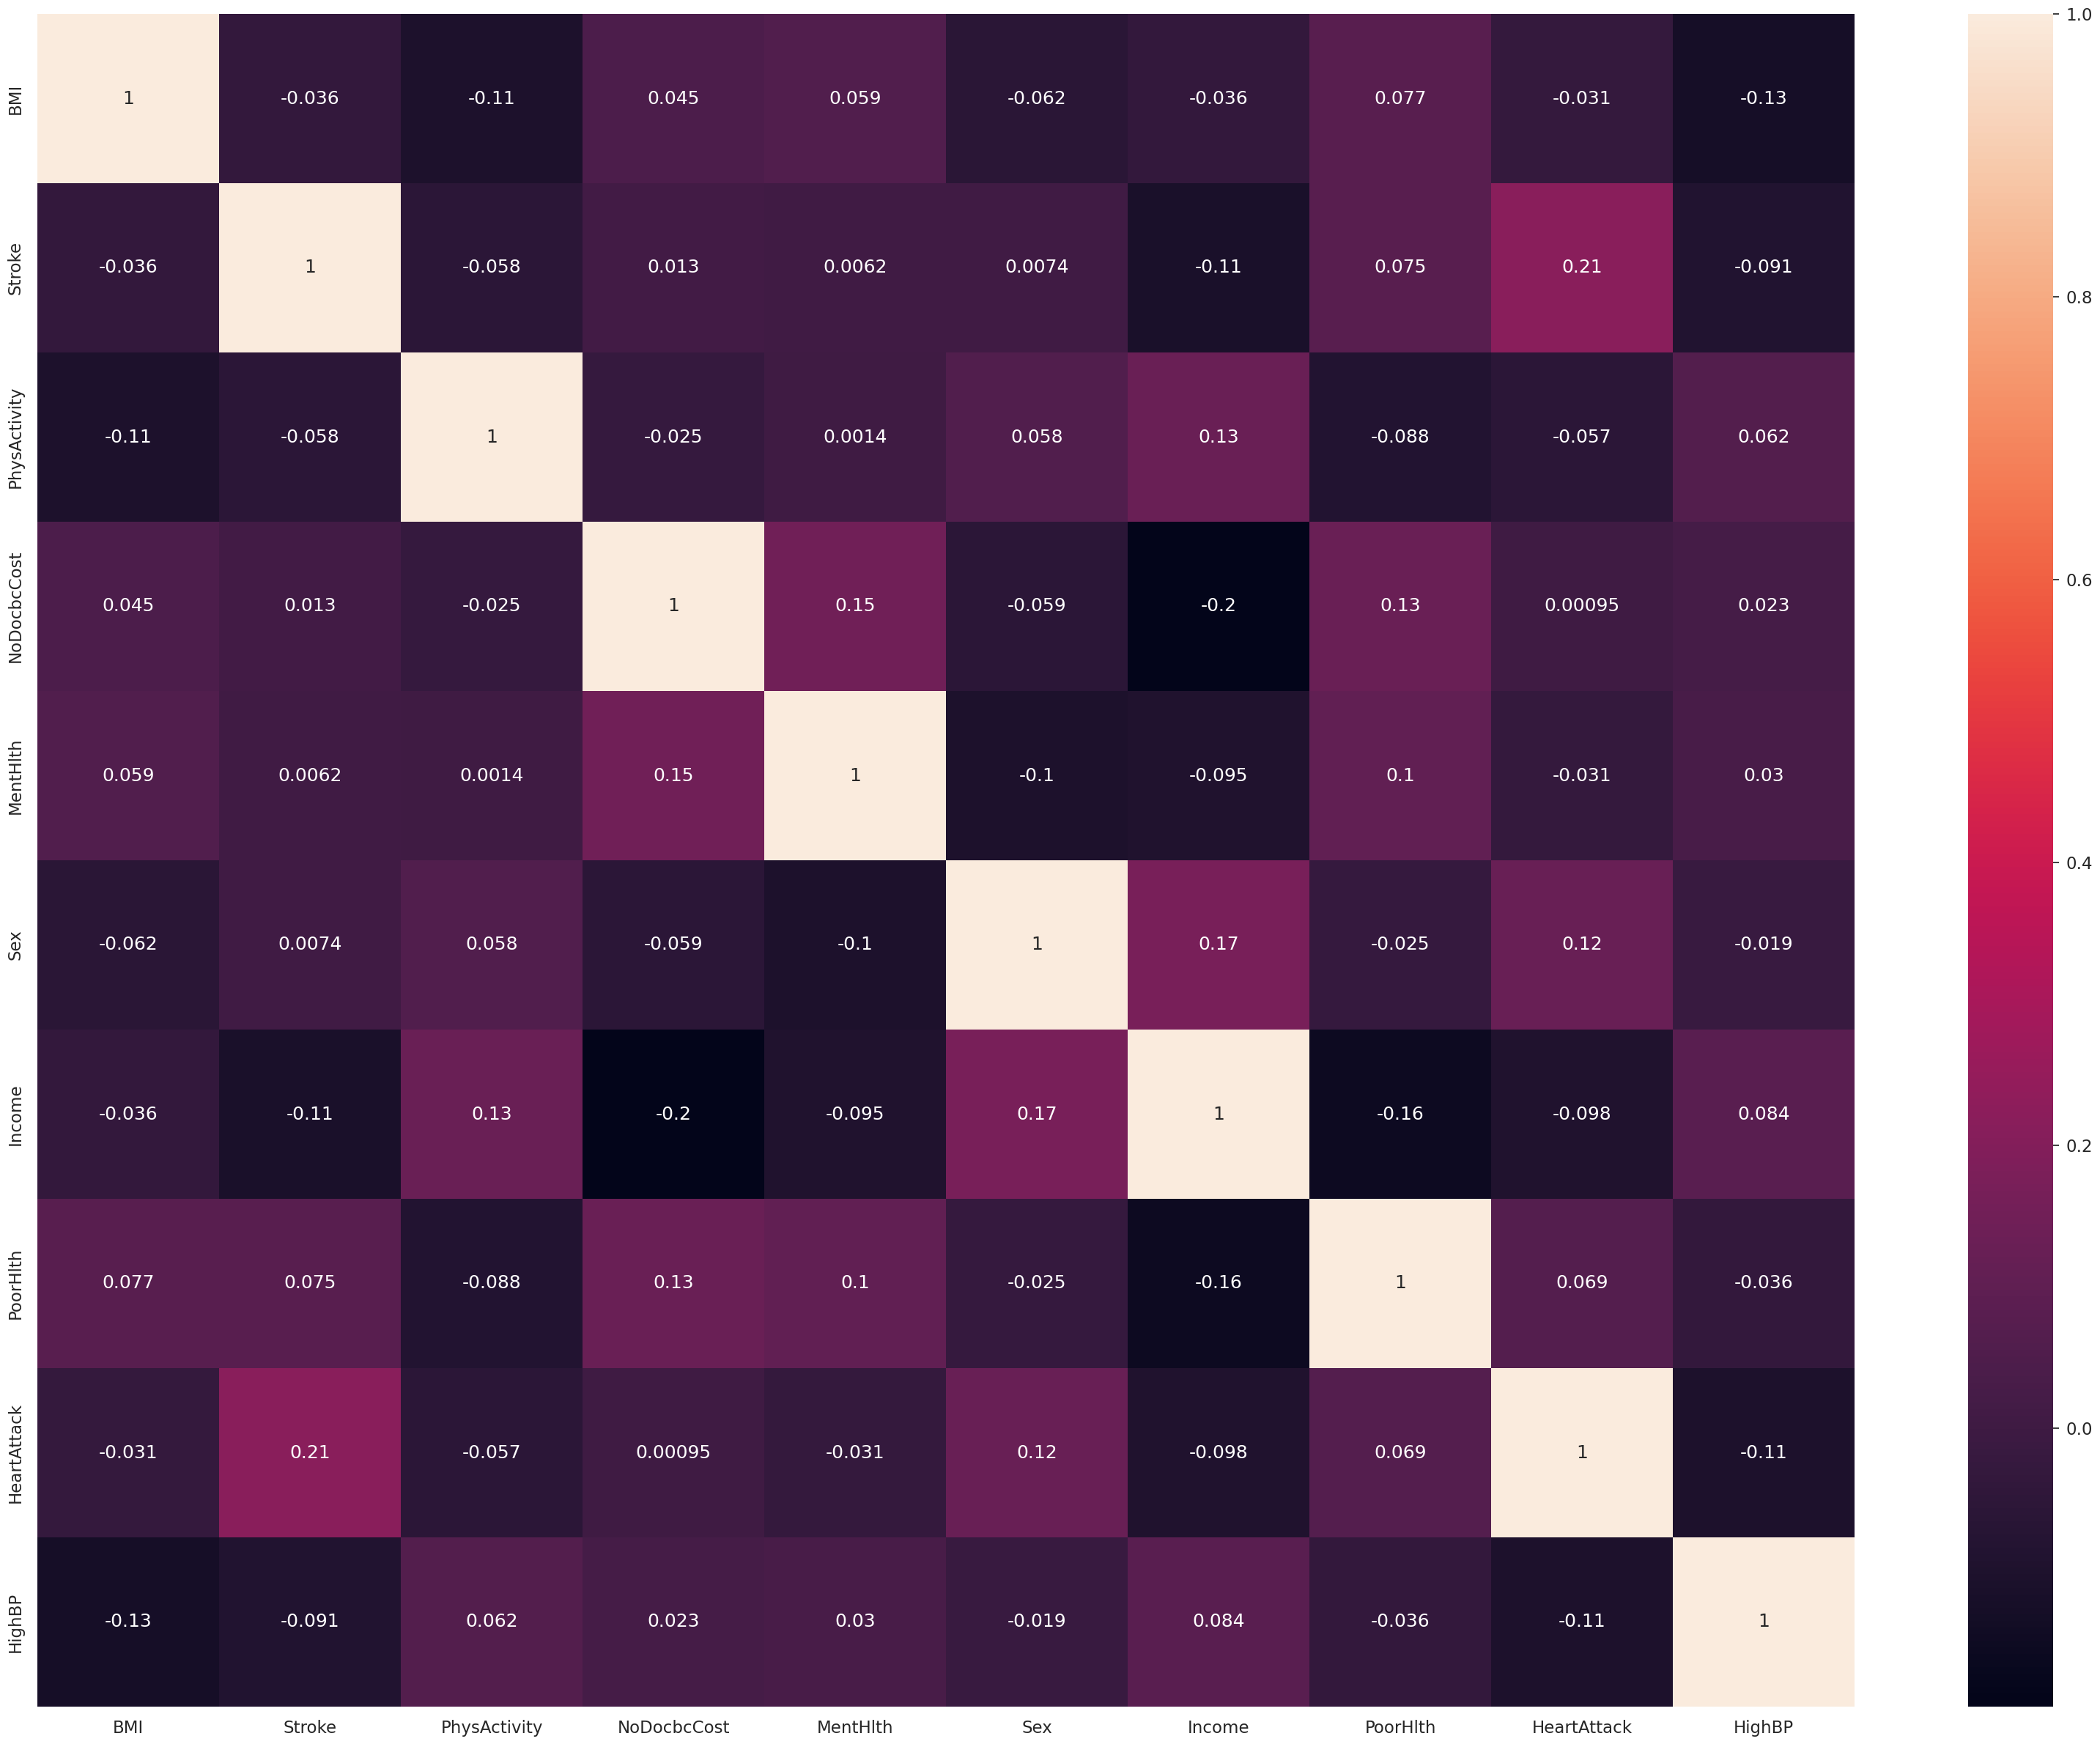

In [40]:
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are still features that are moderately correlated. We will eliminate one of the features for each correlated pair to reduce collinearity. 

## Create training and testing data sets

In [41]:
y = data['Diabetes_012']
x = data.drop('Diabetes_012',axis=1)
print('Available Features',x.columns)
from sklearn.model_selection import train_test_split
x_tr_1, x_tst_1, y_tr_1, y_tst_1 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=0)

Available Features Index(['BMI', 'Stroke', 'PhysActivity', 'NoDocbcCost', 'MentHlth', 'Sex',
       'Income', 'PoorHlth', 'HeartAttack', 'HighBP'],
      dtype='object')


## Initial Multinomial Logistic Regression Models

### Statsmodels 

In [42]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
x_tr_1_const = add_constant(x_tr_1)
print(Logit(y_tr_1, x_tr_1_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.341024
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:                66140
Model:                          Logit   Df Residuals:                    66129
Method:                           MLE   Df Model:                           10
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.03092
Time:                        03:03:26   Log-Likelihood:                -22555.
converged:                       True   LL-Null:                       -23275.
Covariance Type:            nonrobust   LLR p-value:                3.132e-303
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0521      0.052    -39.217      0.000      -2.155      -1.950
BMI             -0.1454

We can see that our model is doing an ok job, but could be improved. 
All of our p-values indicate that our predictors are statistically significant and related to our outcome.

In [43]:
x_tr_2, x_tst_2, y_tr_2, y_tst_2 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=1)
x_tr_2_const = add_constant(x_tr_2)
print(Logit(y_tr_2, x_tr_2_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.340245
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:                66140
Model:                          Logit   Df Residuals:                    66129
Method:                           MLE   Df Model:                           10
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.03314
Time:                        03:03:28   Log-Likelihood:                -22504.
converged:                       True   LL-Null:                       -23275.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0772      0.052    -39.670      0.000      -2.180      -1.975
BMI             -0.1508

Both models are performing about the same.
However, we have a lot of attributes, and will need to try other approaches and methods to see whether we can drop some of them or use other approaches to improve performance.


In [44]:
y_new = data['Diabetes_012']
x_new = data.drop('Diabetes_012',axis=1)

In [45]:
x_tr_sk, x_tst_sk, y_tr_sk, y_tst_sk = train_test_split(x_new,y_new,test_size = 0.25, shuffle=True, stratify=y,random_state=0)

In [46]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter = 2500, solver='newton-cg', class_weight='balanced')
logit.fit(x_tr_sk,y_tr_sk)
y_pred = logit.predict(x_tst_sk)
y_true = y_tst_sk

Training accuracy:
0.61
Test accuracy:
0.62


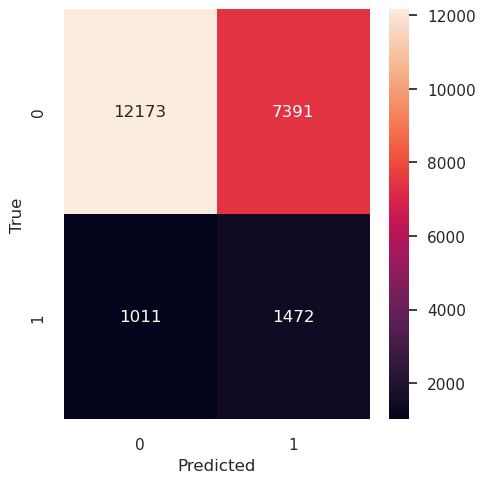

In [47]:
from sklearn.metrics import accuracy_score
print("Training accuracy:")
print(np.round(accuracy_score(y_tr_sk,logit.predict(x_tr_sk)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_true,y_pred),2))

from sklearn.metrics import confusion_matrix
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_true,y_pred)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


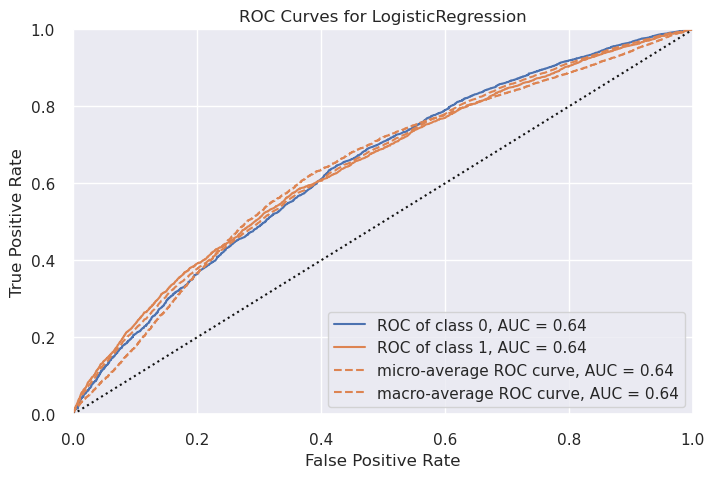

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [48]:
from yellowbrick.classifier import ROCAUC
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit,classes=[0,1])
visualizer.fit(x_tr_sk, y_tr_sk)
visualizer.score(x_tst_sk, y_tst_sk) 
visualizer.show() 

The model is performing similarly for both classes, but could be improved. 


In [49]:
from sklearn.feature_selection import RFE

x_rfe = data.drop(columns=['Diabetes_012'])
y_rfe = data['Diabetes_012']
train_x_rfe, test_x_rfe, train_y_rfe, test_y_rfe = train_test_split(x_rfe, y_rfe, test_size = 0.25, shuffle=True, stratify=y, random_state=0)
logit_rfe = LogisticRegression(max_iter=2500,solver='newton-cg', class_weight='balanced')
rfe = RFE(logit_rfe)
fit = rfe.fit(train_x_rfe,train_y_rfe)

In [50]:
col = x_rfe.columns
RFE_sup = rfe.support_
RFE_rank = rfe.ranking_
dataset = pd.DataFrame({'Columns': col, 'RFE_support': RFE_sup, 'RFE_ranking': RFE_rank}, columns=['Columns', 'RFE_support', 'RFE_ranking'])
df = dataset[(dataset["RFE_support"] == True) & (dataset["RFE_ranking"] == 1)]
filtered_features = df['Columns']
filtered_features

2    PhysActivity
3     NoDocbcCost
4        MentHlth
8     HeartAttack
9          HighBP
Name: Columns, dtype: object

In [51]:
new_train_x_rfe = train_x_rfe[filtered_features]
new_test_x_rfe = test_x_rfe[filtered_features]

In [52]:
model = Logit(train_y_rfe, new_train_x_rfe).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.432693
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:                66140
Model:                          Logit   Df Residuals:                    66135
Method:                           MLE   Df Model:                            4
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 -0.2296
Time:                        03:03:49   Log-Likelihood:                -28618.
converged:                       True   LL-Null:                       -23275.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
PhysActivity    -1.2089      0.018    -67.802      0.000      -1.244      -1.174
NoDocbcCost     -0.3690

In [53]:
logit_rfe = LogisticRegression(max_iter = 2500, class_weight='balanced')
logit_rfe.fit(new_train_x_rfe,train_y_rfe)
y_pred_rfe = logit_rfe.predict(new_test_x_rfe)
y_true_rfe = test_y_rfe

Training accuracy:
0.56
Test accuracy:
0.57


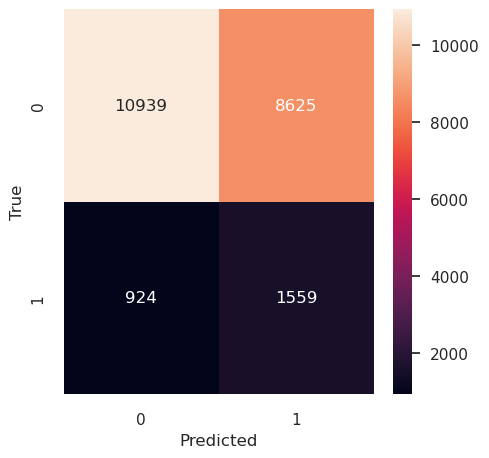

In [54]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(test_y_rfe,y_pred_rfe)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_rfe,logit_rfe.predict(new_train_x_rfe)),2))
print("Test accuracy:")
print(np.round(accuracy_score(test_y_rfe,y_pred_rfe),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


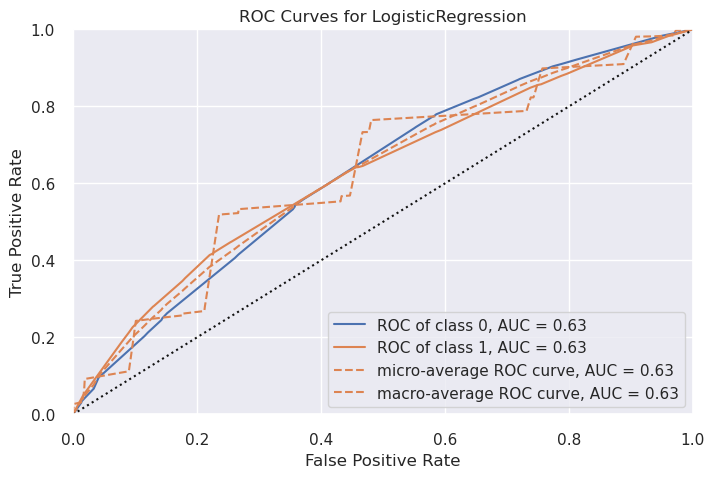

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [55]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_rfe,classes=[0,1,2])
visualizer.fit(new_train_x_rfe, train_y_rfe)
visualizer.score(new_test_x_rfe, test_y_rfe) 
visualizer.show() 

In [56]:
data = data[['Diabetes_012','PhysActivity','NoDocbcCost','MentHlth','HeartAttack','HighBP']]

In [57]:
x_rfe = data.drop(columns=['Diabetes_012'])
y_rfe = data['Diabetes_012']
train_x_rfe, test_x_rfe, train_y_rfe, test_y_rfe = train_test_split(x_rfe, y_rfe, test_size = 0.25, shuffle=True, stratify=y, random_state=0)
logit_rfe = LogisticRegression(max_iter=2500,solver='newton-cg', class_weight='balanced')
rfe = RFE(logit_rfe)
fit = rfe.fit(train_x_rfe,train_y_rfe)

In [58]:
col = x_rfe.columns
RFE_sup = rfe.support_
RFE_rank = rfe.ranking_
dataset = pd.DataFrame({'Columns': col, 'RFE_support': RFE_sup, 'RFE_ranking': RFE_rank}, columns=['Columns', 'RFE_support', 'RFE_ranking'])
df = dataset[(dataset["RFE_support"] == True) & (dataset["RFE_ranking"] == 1)]
filtered_features = df['Columns']
filtered_features

3    HeartAttack
4         HighBP
Name: Columns, dtype: object

In [59]:
new_train_x_rfe = train_x_rfe[filtered_features]
new_test_x_rfe = test_x_rfe[filtered_features]

In [60]:
new_train_x_rfe_const = add_constant(new_train_x_rfe)
model = Logit(train_y_rfe, new_train_x_rfe_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.344849
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:                66140
Model:                          Logit   Df Residuals:                    66137
Method:                           MLE   Df Model:                            2
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                 0.02005
Time:                        03:04:00   Log-Likelihood:                -22808.
converged:                       True   LL-Null:                       -23275.
Covariance Type:            nonrobust   LLR p-value:                1.959e-203
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.1983      0.016   -134.482      0.000      -2.230      -2.166
HeartAttack    -0.5118    

In [61]:
logit_rfe = LogisticRegression(max_iter = 2500, solver='newton-cg', class_weight='balanced')
logit_rfe.fit(new_train_x_rfe,train_y_rfe)
y_pred_rfe = logit_rfe.predict(new_test_x_rfe)
y_true_rfe = test_y_rfe

Training accuracy:
0.73
Test accuracy:
0.73


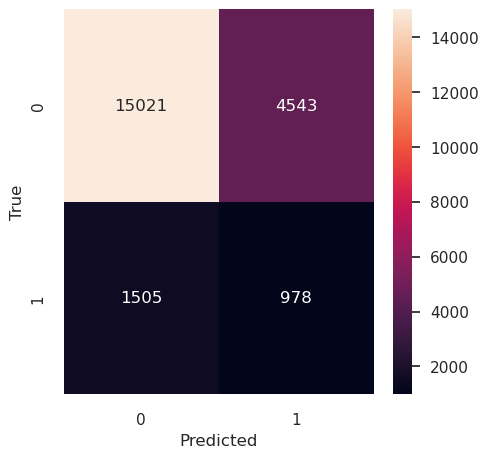

In [62]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(test_y_rfe,y_pred_rfe)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_rfe,logit_rfe.predict(new_train_x_rfe)),2))
print("Test accuracy:")
print(np.round(accuracy_score(test_y_rfe,y_pred_rfe),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


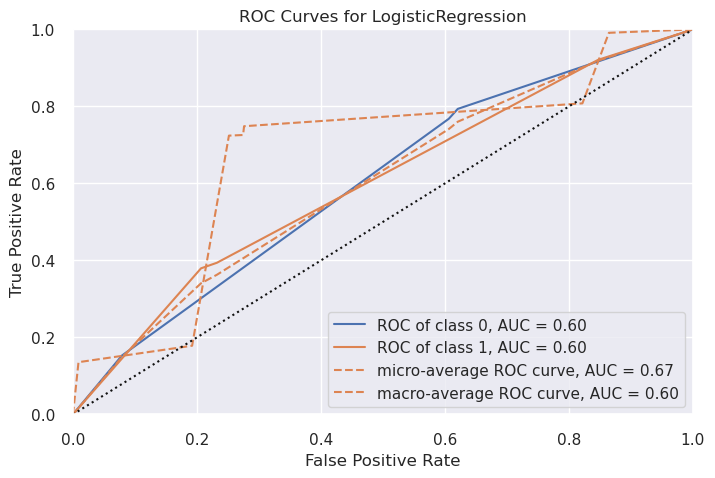

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_rfe,classes=[0,1,2])
visualizer.fit(new_train_x_rfe, train_y_rfe)
visualizer.score(new_test_x_rfe, test_y_rfe) 
visualizer.show() 

### Principal Component Analysis

In [64]:
from sklearn.preprocessing import StandardScaler

y_sc = data['Diabetes_012']
x_sc = data.drop('Diabetes_012',axis=1)

scaler = StandardScaler()
x_tr = scaler.fit_transform(x_sc)


In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
pca.fit(x_tr)

PCA()

In [66]:
print('Variance Explained - %')
print(pca.explained_variance_ratio_ * 100)


Variance Explained - %
[23.64569553 22.53141969 18.96668125 17.93674968 16.91945384]


Text(0, 0.5, 'explained variance')

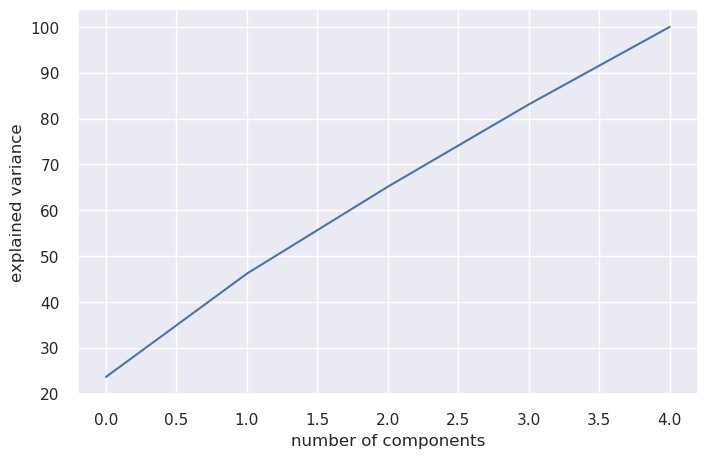

In [67]:
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('number of components')
plt.ylabel('explained variance')